In [1]:
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import warnings
import scipy
warnings.simplefilter(action='ignore', category=FutureWarning)          #some code samples return useless warnings, this suppresses them
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

plt.style.use("fivethirtyeight")

dataDir = "./data/"     #folder containing the data
adjMatrix = np.genfromtxt(dataDir+"adjacency_matrix.csv", delimiter=",",dtype="int")
featMatrix = np.genfromtxt(dataDir+"feature_matrix.csv", delimiter=",",dtype="int")

# <a id="indeces">Task 1.1</a>

We first implement two metrics to evaluate the quality of clusterings, not already present in sklearn: the Dunn and PBM indexes. The first is one of the variants described in [2](#references), namely $\nu_{53}$. This looks at the average diamter and average distance between clusters, rather than the usual metric of looking at the maximum diameter and maximum distance between clusters. By looking at the average, the metric isn't as susceptible to outliers and inliers which can easily change the value of the index even by a few orders of magnitude.
The PBM index is described in [1](#references) where it is shown to outperform other common indexes in determining the optimal number of clusters. It is defined as:
$$
PBM = \left(\frac 1K \times \frac{E_1}{E_K}\times D_K\right)^2
$$
Where $K$ is the number of clusters, $D_K$ is the maximum distance between the centroids of the clusters and $E_K$ is the compactness of the clusters. In particular $E_K = \sum_{k=1}^K\sum_{x\in C_k}\|x - c_k\|$, where $c_k$ is the centroid of the $k$-th cluster, while $E_1=\sum_{x\in X}\|x-\bar{x}\|$, where $\bar{x}$ is the centre of the whole dataset. By taking into account the number of clusters, it avoids favouring divisions into more clusters as is common with many of the other indeces. 


In [2]:
from sklearn.metrics.pairwise import euclidean_distances

def distanceFromPoint(X, centre):
    """
    Returns the sum of the distances of the points in X to the specified centre
    X: a (nPoints, nDim) matrix, where every row should represent a single point
    centre: a (nDim) vector
    """
    return sum(euclidean_distances(X, [centre]))[0]

def getClusterDistances(X, labels, centroids):
    """
    Returns a matrix with the distances between clusters. This is defined as
    the average distance between points in one cluster to the centre of the 
    other.
    X: a (nPoints, nDim) matrix, where every row should represent a single point
    labels: a (nPoints) numpy array with the labels for each point, should be in the 
    interval 0,..., nClusters-1
    centroids: an array containing the centroid of each cluster
    """
    nClusters = len(np.unique(labels))
    clusterDistances = np.zeros((nClusters, nClusters))
    for i in range(nClusters-1):
        for j in range(i + 1, nClusters):   #only need to calculate the upper triangular section as matrix is symmetric
            #distance of points in cluster i from the j-th centroid
            clusterDistances[i][j] = distanceFromPoint(X[labels == i], centroids[j])
            #distance of points in cluster j from the i-th centroid
            clusterDistances[i][j] += distanceFromPoint(X[labels == j], centroids[i])
            clusterDistances[i][j] /= sum(labels == i) + sum(labels == j)
            clusterDistances[j][i] = clusterDistances[i][j]
    
    return clusterDistances

def getDiameters(X, labels, centroids):
    """
    Returns a vector of the average diameter of the clusters
    X: a (nPoints, nDim) matrix, where every row should represent a single point
    labels: a (nPoints) numpy array with the labels for each point, should be in the 
    interval 0,..., nClusters-1
    centroids: an array containing the centroid of each cluster
    """
    nClusters = len(np.unique(labels))
    #the diameter is the average distance of points in a cluster from the centroid
    diameters = 2 * np.array([distanceFromPoint(X[labels == k], centroids[k]) for k in range(nClusters)])

    #divide each diameter by the number of points in each cluster to average
    for i in range(len(diameters)):
        diameters[i] /= sum(labels == i)
    return diameters

def getCompactness(X, centroids, labels):
    """
    Returns a vector of the compactness of a certain clustering division, defined 
    as the sum of the compactness of each cluster, which in turn is the sum of 
    the distances of the points from the centroid.
    X: a (nPoints, nDim) matrix, where every row should represent a single point
    labels: a (nPoints) numpy array with the labels for each point, should be in the 
    interval 0,..., nClusters-1
    centroids: an array containing the centroid of each cluster
    """
    nClusters = len(np.unique(labels))
    compactness = 0
    for k in range(nClusters):
        compactness += distanceFromPoint(X[labels == k], centroids[k])
    return compactness 

def dunn(X, labels, centroids):
    """
    Returns the dunn index of a certain division. See above for more information
    X: a (nPoints, nDim) matrix, where every row should represent a single point
    labels: a (nPoints) numpy array with the labels for each point, should be in the 
    interval 0,..., nClusters-1
    centroids: an array containing the centroid of each cluster
    """
    labels = np.array(labels)
    clusterDistances = getClusterDistances(X, labels, centroids)
    
    #maximum distance between clusters
    minDistance = min(clusterDistances[clusterDistances.nonzero()]) 
    #maximum diameter of any one cluster
    maxDiameter = max(getDiameters(X, labels, centroids))

    return minDistance / maxDiameter

def PBM(X, labels, centroids):
    """
    Returns the PBM-index of a certain division. See above for more information
    X: a (nPoints, nDim) matrix, where every row should represent a single point
    labels: a (nPoints) numpy array with the labels for each point, should be in the 
    interval 0,..., nClusters-1
    centroids: an array containing the centroid of each cluster
    """
    labels = np.array(labels)
    nClusters = len(np.unique(labels))
    Dk = np.amax(euclidean_distances(centroids))

    meanPoint = np.average(X, axis = 0)     #centroid for the whole data set
    E1 = distanceFromPoint(X, meanPoint)    #used for normalisation
    EK = getCompactness(X,centroids,labels) 

    PBM = (E1/EK * Dk / nClusters)**2
    return PBM

We now use KMeans to divide the papers into various clusters, k is taken in the range \[2,30\]. KMeansis an inheritly random algorithm, and not particularly robust, getting often stuck in local minimums. In [1](#references) a solution is presented: rerun the algorithm and select the best clustering according to some fixed metric. Sklearn already implements this solution using inertia as a metric, to further reduce the random effects we increment the number of runs. However, this will still result in different results upon different runs, to provide a more coherent discussion we will fix a random seed.

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

def evaluateClusters(X, nInit=30):
    """
    Uses kmeans to divide the data into clusters, with k in the range [2,30].
    It returns an array containing the scores according to different metrics for each cluster.
    """
    #metrics to use to evaluate the quality of clusters, not including PBM and dunn which are treated separately
    metrics = [calinski_harabasz_score, davies_bouldin_score, silhouette_score]
    scores = np.zeros((len(metrics)+2, 29))

    for i in range(2,31):   
        model = KMeans(n_clusters = i, n_init = nInit, random_state = 1, n_jobs = -1)
        model.fit(X)

        for j in range(len(metrics)):
            scores[j][i-2] = metrics[j](X,model.labels_)
        scores[-2][i-2] = dunn(X, model.labels_, model.cluster_centers_)
        scores[-1][i-2] = PBM(X, model.labels_, model.cluster_centers_)
        print("\rProgress: [%d/29]"%(i-1),end="")
    return scores

In [4]:
scoresFeatures = evaluateClusters(featMatrix)
#finds the first value of k with a CH score of less than 7
optimalK = next(i for i, score in enumerate(scoresFeatures[0]) if score < 7) + 2

Progress: [29/29]

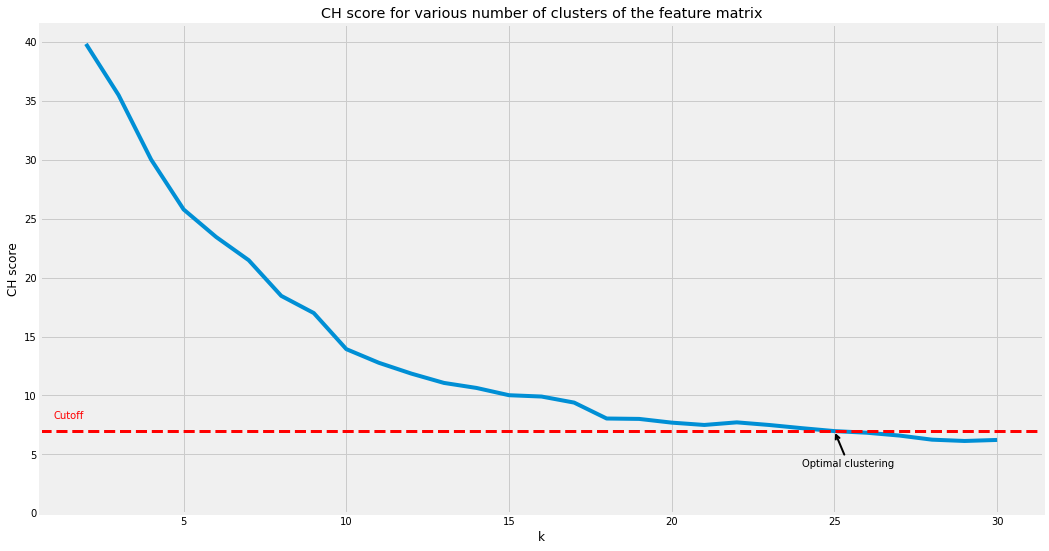

In [5]:
plt.plot(range(2,31),scoresFeatures[0])
plt.xlabel("k")
plt.ylabel("CH score")
plt.ylim(bottom=0)
plt.title("CH score for various number of clusters of the feature matrix")
plt.gca().axhline(y=7,color="red",ls="--",lw=3)
plt.text(1,8,"Cutoff", color="red")
plt.gcf().set_size_inches(16,9)

plt.annotate(
            "Optimal clustering",
            (optimalK,scoresFeatures[0][optimalK-2]),
            xytext=(optimalK-1,scoresFeatures[0][optimalK-2]-3),
            arrowprops={"arrowstyle":"->","color":"black","lw":2}
            )

plt.show()

## Analysing the optimal division
We now retrain the model with the optimal k which has been found (a more efficient way would have been to save the best model during training, but this simpler solution is acceptable given the small computational cost of a single kmeans run).

In [6]:
model = KMeans(n_clusters = optimalK, n_init = 30, random_state = 1, n_jobs = -1)
model.fit(featMatrix)

G = nx.from_numpy_matrix(adjMatrix)
for i in range(len(G.nodes(data=False))):   #save the cluster labels on the graph for future use
    G.nodes[i]["cluster"] = model.labels_[i]

To get a better idea of what the division looks like, we compute and plot some of the well-known descriptors of the clusters, to get an intuitive grasp on some of its basic properties.

In [7]:
labels = model.labels_
centroids = model.cluster_centers_
clusterSize = [0]*optimalK          #number of papers in each cluster
withinSimilarity = [0]*optimalK     #within group similarity, defined as the average distance from the centroid
acrossSimilarity = [0]*optimalK     #across group similarity, defined as the minimum distance to the centroid of a different cluster

#precompute as is 2x more efficient by not having to compute symmetric terms twice
clusterDistances = getClusterDistances(featMatrix,labels,centroids)
#remove diagonal entries representing distance from a cluster to itself
clusterDistances = clusterDistances[clusterDistances.nonzero()].reshape(optimalK,-1)

for label in range(optimalK):
    clusterSize[label] = sum(labels == label)
    withinSimilarity[label] = distanceFromPoint(featMatrix[labels == label], centroids[label]) / clusterSize[label]
    acrossSimilarity[label] = min(clusterDistances[label])

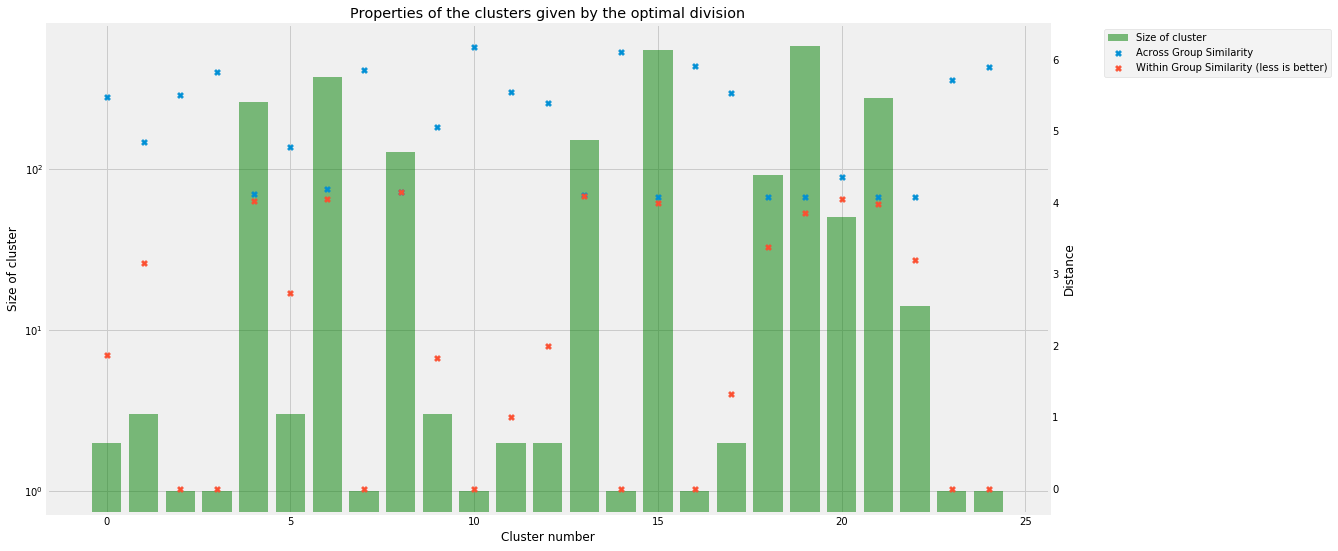

In [8]:
ax = plt.gca()
plt.grid(True)
bar = ax.bar(list(range(optimalK)),clusterSize,alpha=0.5, color="green")
ax.set_yscale("log")
ax.set_ylabel("Size of cluster")
ax.set_xlabel("Cluster number")

ax = plt.gca().twinx()
plt.grid(False)
a = ax.scatter(list(range(optimalK)),acrossSimilarity,marker="X")
c = ax.scatter(list(range(optimalK)),withinSimilarity,marker="X")
ax.set_ylabel("Distance")
plt.legend((bar,a,c),("Size of cluster","Across Group Similarity","Within Group Similarity (less is better)"),bbox_to_anchor=(1.05, 1))
plt.gcf().set_size_inches(16,9)

_ = plt.title("Properties of the clusters given by the optimal division")

The most striking characteristic of this dvision is the presence of many very small clusters: in particular, there are 15 clusters with at most 3 papers out of a total of 25. This indcates one of two things: either we have fallen into a local minimum, but we wouldn't expect one so severe since we have re-run the kmeans algorithm 30 times, or our choice of an optimal k wasn't as ideal as we could have hoped. This seems reasonable given the metric we used to select such a k was somewhat arbitrary. If we were to exclude the 15 small clusters we would end up with 10 clusters, we will see later if other metrics support this conclusion.

Once again ignoring the outliers, we see very little variation in the across and within group similarity indeces, and the two are also very similar between each other. Given the meaning of the two metrics, this suggests that the clusters are close to tassellating the space, meaning that they are very tightly packed. This might indicate that the papers tend to lie on a continuum, with many papers not lieing clearly within one subject area, however this is mostly pure speculation as the two metrics aren't sufficient to come to this conclusion. As expected the small clusters have very high within group similarity, after all they can only be somewhat spread out given the small number of points. What is less expected is there high value for across group separation, the metric is normalised by size so we wouldn't expect it to be influenced by size. Smaller clusters might have higher variability, but then we would expect half of them to have uncharacteristically _low_ values. This indicates that these points might just be outliers, which have forced the clustering algorithm to separate them from the others. We might then get a cleaner separation by removing some or most of them before performing our analysis, but it sin't at all clear how one would go about this a priori.

## Evaluating quality of the division
We now use 4 new metrics to evaluate the quality of the divisions: Davies-Bouldin, Silhouette Width, Dunn and PBM indeces. The last two have already been discussed [here](#indeces). Silhouette width looks at how similar each point is to its cluster compared to the other clusters. For each point it generates a value between 1 and -1, with 1 indicating that the point has been inserted in the correct cluster, while -1 indicates that a better cluster could have been chosen. It then averages this value across all points, hence a good clustering will have a silhouette width close to 1.

Davies-Bouldin is instead a metric acting on each cluster rather than on each point. It first measure the compactness of each cluster defined as the average radius, and then compares it to the distance to other clusters. In general we expect the sum of the radii of two cluster to be smaller than the distance between them otherwise it would seem to indicate some overlap. Davies-Bouldin thus takes the maximum value of the ratio between the sum of the radii and the distance between clusters for each cluster and averages it, a lower value indicates a better clustering.

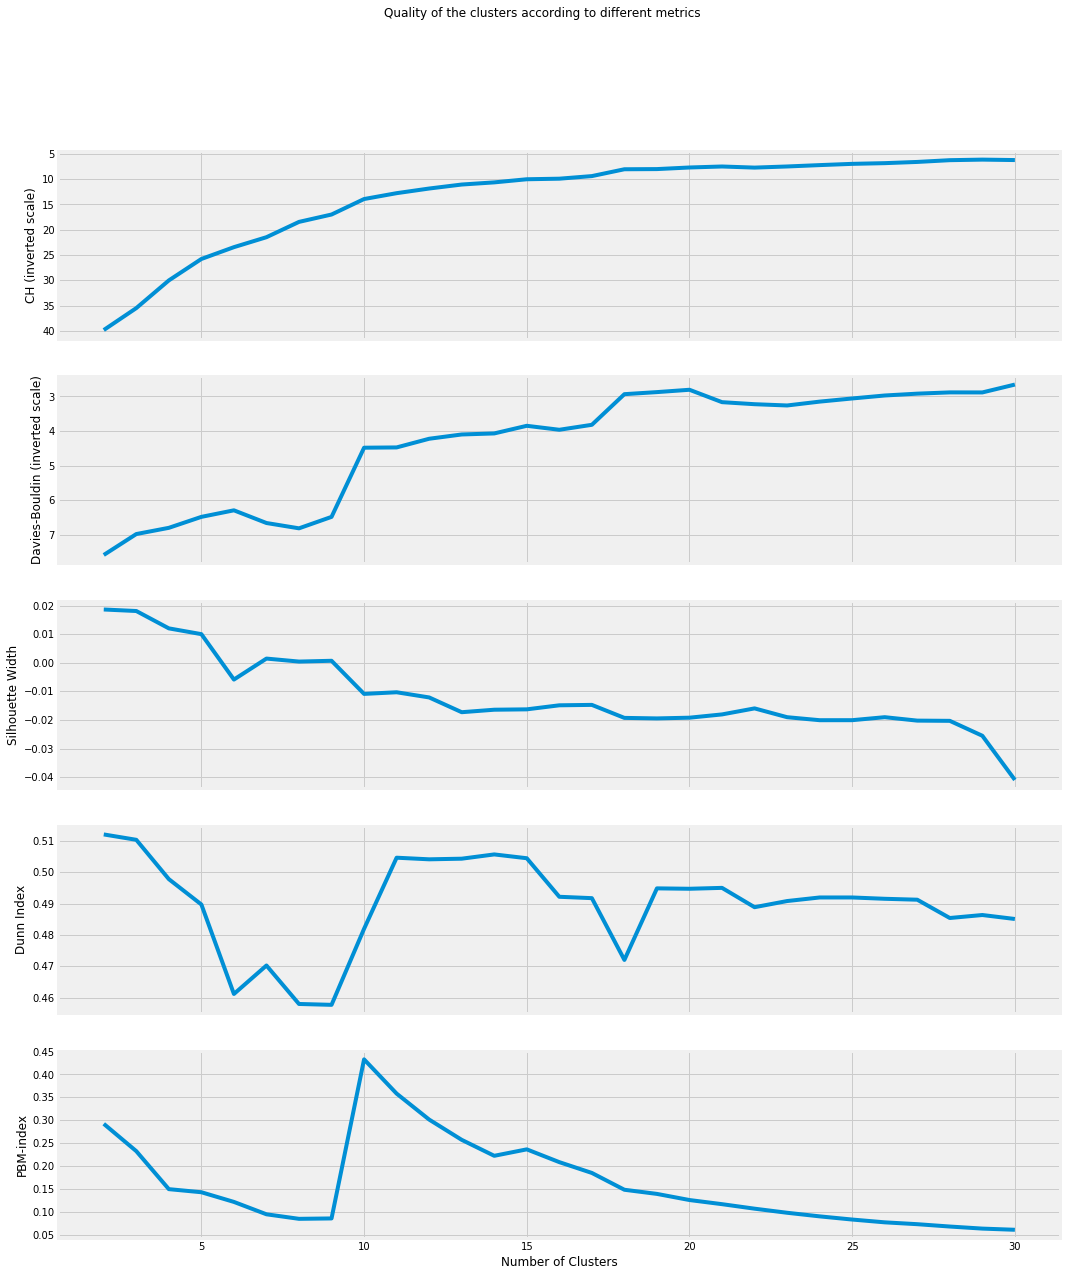

In [9]:
isMoreBetter = [False,False,True,True,True]
metricNames = ["CH", "Davies-Bouldin", "Silhouette Width", "Dunn Index", "PBM-index"]
def plotClusteringScores(scores, title):
    f, axes = plt.subplots(nrows = len(metricNames), ncols = 1, sharex = True)

    for i in range(len(metricNames)):
        axes[i].plot(range(2,31), scores[i])
        inverted = ""

        if not isMoreBetter[i]:
            axes[i].invert_yaxis()
            inverted = " (inverted scale)"

        axes[i].set_ylabel(metricNames[i]+inverted)
    f.set_size_inches(16,20)
    axes[-1].set_xlabel("Number of Clusters")
    f.suptitle(title)

plotClusteringScores(scoresFeatures,"Quality of the clusters according to different metrics")

Note that the first two plots are inverted, as for thhose two metrics, lower values indicate better clustering. 

As mentioned above, PBM has shown itself to be one of the best indeces for deciding the optimal number of clusters, and here we might see further evidence of it: it is the only one with a very clear spike which happens to be at exactly 10 clusters which was the number suggested by looking at the cluster sizes. Silhouette width seems to be almost completely inconclusive, giving a score extremely close to zero to all possible clusterings, with no discernable peak and a general downwards trend. Dunn index is also quite incloncusive as all the values are in a very small interval differing by at most 10% between the best and worst clustering, though it has to be noted that it seems to very loosely follow the trend of PBM with, for example, a big trough between about 4 and 9 clusters, but this might just be a coincidence. 

DB seems to favour division into bigger clusters above all else, however we can see a very big increase in the value of the index between 9 and 10, much bigger than in all other cases. If we accept that DB doesn't sufficiently penalise bigger division this might be further indication that 10 is indeed the best number of labels. Finally CH seems to asymptotically decrease with the number of clusters: this can be somewhat expected, after all KMeans is actually implemented so as to minimise this score ao having more clusters will give it more degrees of freedom to achieve this. The "elbow-point" where the increase in number of clusters stops improving the quality of the cluster, does indeed seem to lie close to 10. 

CH measures the ratio between the between group scatter and the within group scatter. Ie respecitibely, how far the clusters are from the centre of the dataset and the sum of the distances of the observations from the corresponding centroid. It is then multiplied by $\frac{N-k}{k-1}$ where $N$ is the total number of observations. Assuming $k\ll N$ this is roughly equal to $N/k$, and as $N$ is constant, it can be seen to correspond to the $1/k$ term in PBM.

One final note on the robustness of the results: though kMeans is a random algorithm, by repeating the process many times and only selecting the best division, we reduce the variation in results. It could be further reduced by increasing the number of times the process is re-initialised, however, already with 30 restarts, the results don't vary that much across runs.

# Task 1.2
We now look at the properties of the citation graph; we expect the citation graph to indicate communities similar to the ones obtained by looking at the content of the papers, as they should both represent topics in a particular subject area. We start by visualising the graph itself.

In [10]:
graphPos = nx.kamada_kawai_layout(G)    #very slow, spring layout is faster, but produces a worse plot

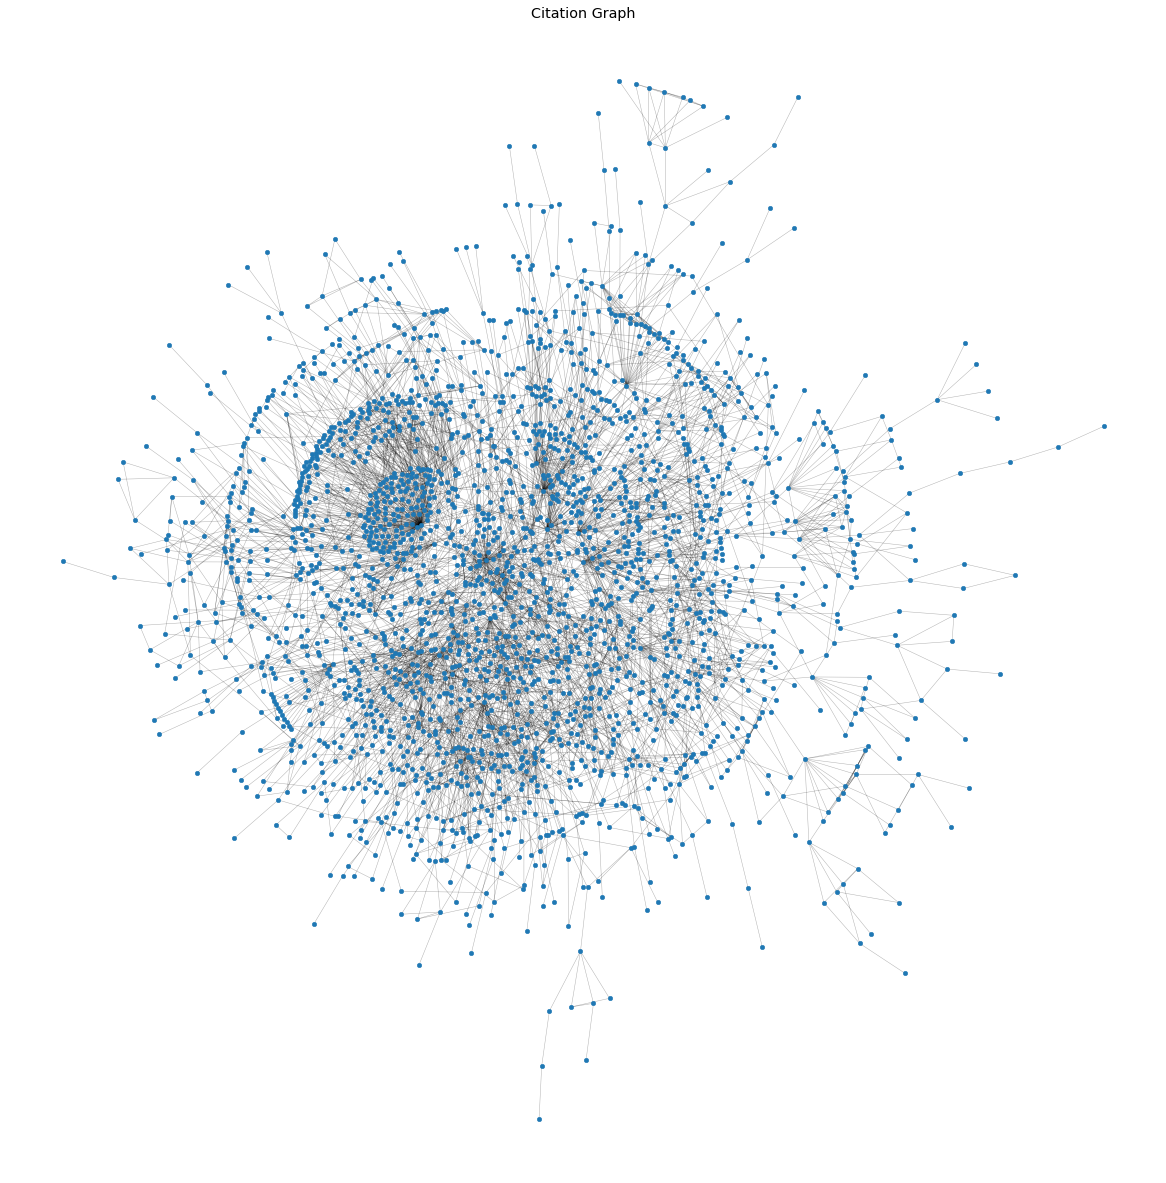

In [11]:
kwargsGraphDraw = {"pos":graphPos,"node_size":20,"width":0.5,"edge_color":(0,0,0,0.3)}
nx.draw(G, **kwargsGraphDraw)
plt.gcf().set_size_inches(16,16)
_ = plt.title("Citation Graph")

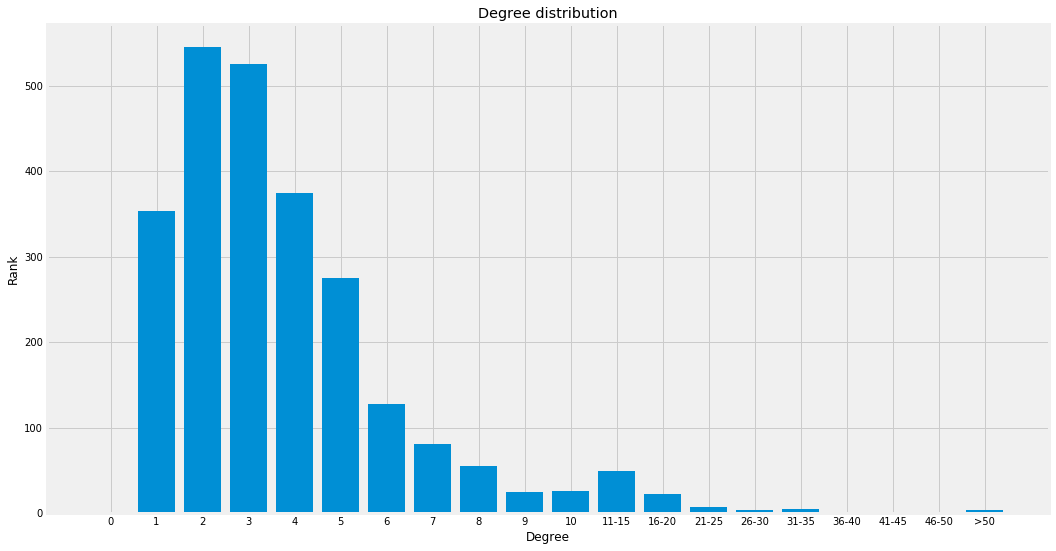

In [12]:
degreesDict = dict(G.degree())
degrees = np.sort(np.fromiter(degreesDict.values(), dtype=int))
bins = [np.count_nonzero(degrees == i) for i in range(11)]
bins += [np.count_nonzero(np.logical_and(degrees <= 5*(i+1), degrees > 5*i)) for i in range(2,10)]
bins += [np.count_nonzero(degrees > 50)]

binlabels = [str(i) for i in range(11)] + ["%d-%d"%(5*i+1,5*(i+1)) for i in range(2,10)] + [">50"]
xpos = list(range(len(bins)))

plt.bar(xpos, bins, align='center', alpha=1)
plt.xticks(xpos, binlabels)
plt.xlabel("Degree")
plt.ylabel("Rank")
plt.title("Degree distribution")

plt.gcf().set_size_inches(16,9)

The simplest metric of importance for a paper is the number of other papers which cite it. By plotting the distribution of the degree, we see that most papers have only been cited a handful of times, with only about 100 (5% of the total) receiving more than 10. This indicates only a few important papers. We now computer other measures of importance and try to compare it to that given by the degree.

In [13]:
pageranksDict = nx.pagerank(G)
pageranks = sorted(list(pageranksDict.values()))
betweennessCentralityDict = nx.betweenness_centrality(G)
betweennessCentrality = sorted(list(betweennessCentralityDict.values()))

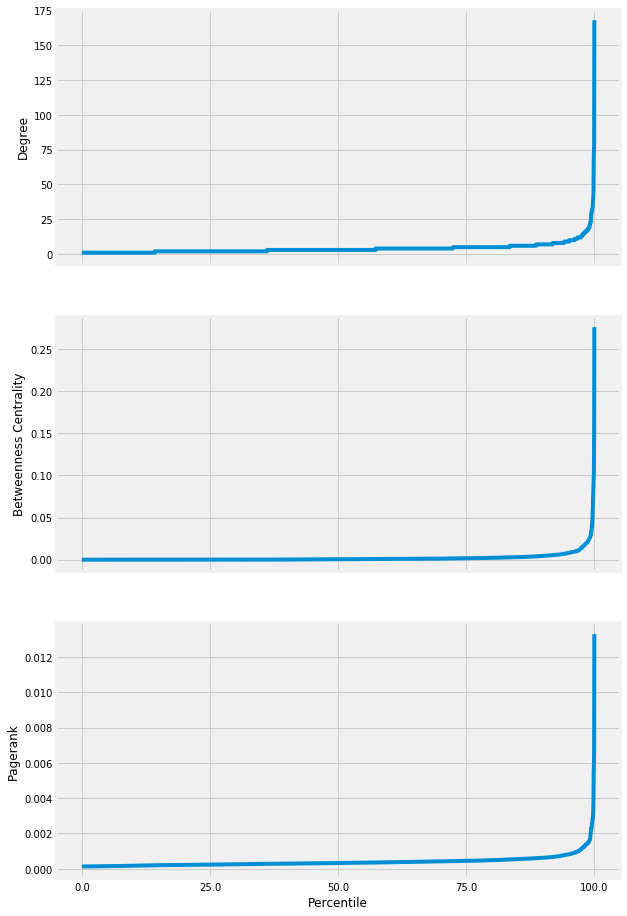

In [14]:
measures = [degrees,betweennessCentrality,pageranks]
measureLabels = ["Degree", "Betweenness Centrality","Pagerank"]
p = np.linspace(0,100,21)
f,axes = plt.subplots(3,1,sharex=True)

for i, ax in enumerate(axes):
    ax.plot(measures[i])
    ax.set_ylabel(measureLabels[i])

sparsity = 5
plt.xticks((len(pageranks)-1) * p[::sparsity]/100., map(str, p[::sparsity]))
plt.xlabel("Percentile")
f.set_size_inches(9,16)

plt.show()


The three graphs look qualitatively very similar, though they do not show to whic node each value corresponds to. Thus we might have different nodes being more or less important. In the following we attempt to verify whether this is the case.

In [15]:
def getRank(a,val):
    """
    list assumed sorted
    """
    return len(a) - np.searchsorted(a,val)

def kBiggestDict(k, dictionary):
    assert(k <= len(dictionary))
    return sorted(dictionary, key=dictionary.get)[-k:]

k=30
biggestDeg = kBiggestDict(k, degreesDict)
biggestPgRnk = kBiggestDict(k, pageranksDict)
biggestBtwnCent = kBiggestDict(k, betweennessCentralityDict)

commonNodes = sorted(list(set(biggestDeg).
                    intersection(biggestPgRnk).
                    intersection(biggestBtwnCent)
               ))
cols = ["Node","Degree","Degree Rank","Pagerank","Pagerank Rank","Btwn Centrality","Btwn Centrality Rank"]
df = pd.DataFrame(columns = cols)

for node in commonNodes:
    deg = degreesDict[node]
    degRank = getRank(degrees, deg)
    pgRnk = pageranksDict[node]
    pgRnkRank = getRank(pageranks, pgRnk)
    btwnCent = betweennessCentralityDict[node]
    btwnCentRank = getRank(betweennessCentrality, btwnCent)
    row = [node,deg,degRank,pgRnk,pgRnkRank,btwnCent,btwnCentRank]

    df.loc[len(df)] = row

colsToConvert = ["Node","Degree","Degree Rank","Pagerank Rank","Btwn Centrality Rank"]
df[colsToConvert] = df[colsToConvert].astype(int)
df.sort_values("Degree Rank")

Node  Degree  Degree Rank  Pagerank  Pagerank Rank  Btwn Centrality  \
10  1245     168            1  0.013302              1         0.276114   
2    271      78            2  0.005511              4         0.090707   
12  1563      74            3  0.006811              2         0.101355   
14  1846      65            4  0.005833              3         0.149763   
13  1672      44            5  0.003957              5         0.062338   
15  1894      40            7  0.003471              6         0.106109   
0     78      36            8  0.002917              8         0.059195   
6    926      34            9  0.002759             10         0.075044   
3    542      33           10  0.002875              9         0.034706   
16  1905      32           12  0.002293             14         0.034345   
1     95      32           12  0.002292             15         0.048991   
7    977      30           15  0.002280             17         0.080662   
11  1418      30           15  0.002285             16         0.026220   
4    666      29           16  0.002530             13         0.035334   
9   1122      26           17  0.002060             18         0.030915   
8   1034      21           24  0.001600             25         0.028025   
5    882      19           29  0.001508             30         0.038678   

    Btwn Centrality Rank  
10                     1  
2                      5  
12                     4  
14                     2  
13                     8  
15                     3  
0                      9  
6                      7  
3                     15  
16                    16  
1                     10  
7                      6  
11                    22  
4                     14  
9                     17  
8                     20  
5                     13

Above we see which nodes are classified as being among the 30 most relevant according to the three metrics. First we note that we have many more elements (17) then we would expect from random chance alone, indicating that the three variables are quite well correlated. Even looking at the specific ranks confirms this, usually being quite similar.

We will now look at how much the three measure are correlated by plotting them against each other and looking at their correlation. As we are not interested in the particular values as much as the relative ranks, we will look at said ranks, which will also allow us to more easily verify correlation.

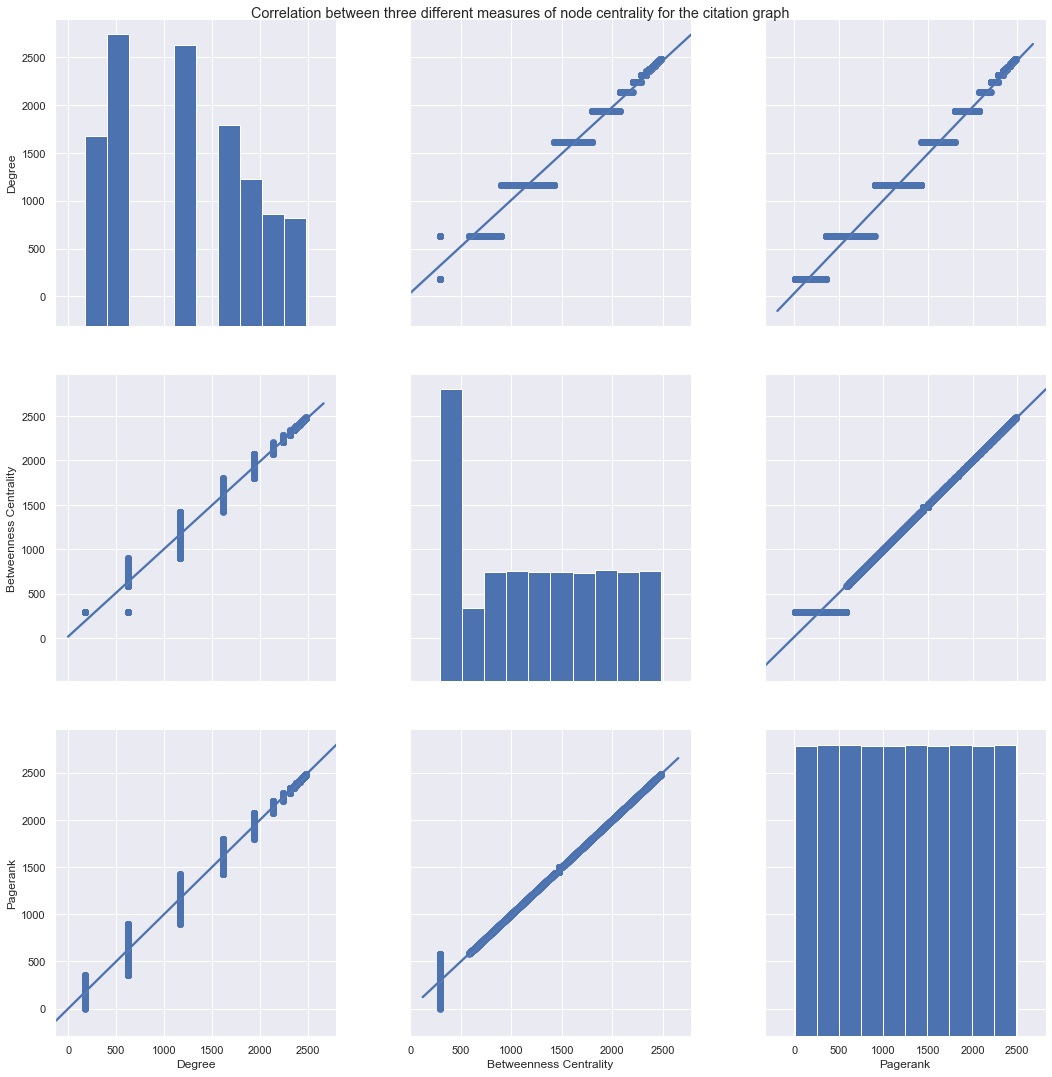

In [16]:
measureRanks = [scipy.stats.rankdata(measure) for measure in measures]
dfGraphCentrality = pd.DataFrame(data=np.transpose(measureRanks),columns=measureLabels)

def pairPlotGraph(data):
    sns.set()
    g=sns.pairplot(data, kind = "reg")
    g.fig.suptitle("Correlation between three different measures of node centrality for the citation graph")
    plt.gcf().set_size_inches(16,16)
    plt.show()
    plt.style.use("fivethirtyeight")
pairPlotGraph(dfGraphCentrality)

Many nodes have the same degree, and quite a few nodes have a betweenness centrlity of 0 (meaning they don't lie on any shortest path), so there will be many ties that will slightly skew the resul, however it is very clear that the correlation between the three variables is extremely high, almost perfect. And in fact the correlation matrix can be seen to confirm this.

In [17]:
dfGraphCentrality.corr()

Degree  Betweenness Centrality  Pagerank
Degree                  1.000000                0.977870  0.985979
Betweenness Centrality  0.977870                1.000000  0.993515
Pagerank                0.985979                0.993515  1.000000

If the three variables weren't as closely correlated, it would have suggested some underlying structure in the graph which here isn't present. For example, a node with high betweenness centrality and low degree indicates that it acts as a link between two different custers. The absence of such a node seems to suggest that different subjects aren't linked by just a few nodes, instead, either such nodes also happen to be particularly important and thus have many citations, or the various disciplines aren't that well clustered, with a smooth transition between two differerent topics. The second options would seem to be supported by the less than ideal clustering we have been able to perform using kmeans.

# Task 1.3
We now try to use the structure of the citation graph (rather than the content of the papers) to partition the papers among communities.

In [18]:
communities = list(nx.algorithms.community.greedy_modularity_communities(G))

communitySizes = []
for i, nodes in enumerate(communities):
    communitySizes += [len(nodes)]   #number of nodes in each community
    for node in nodes:     #save communities onto the nodes
        G.nodes[node]["CNM Community"] = i

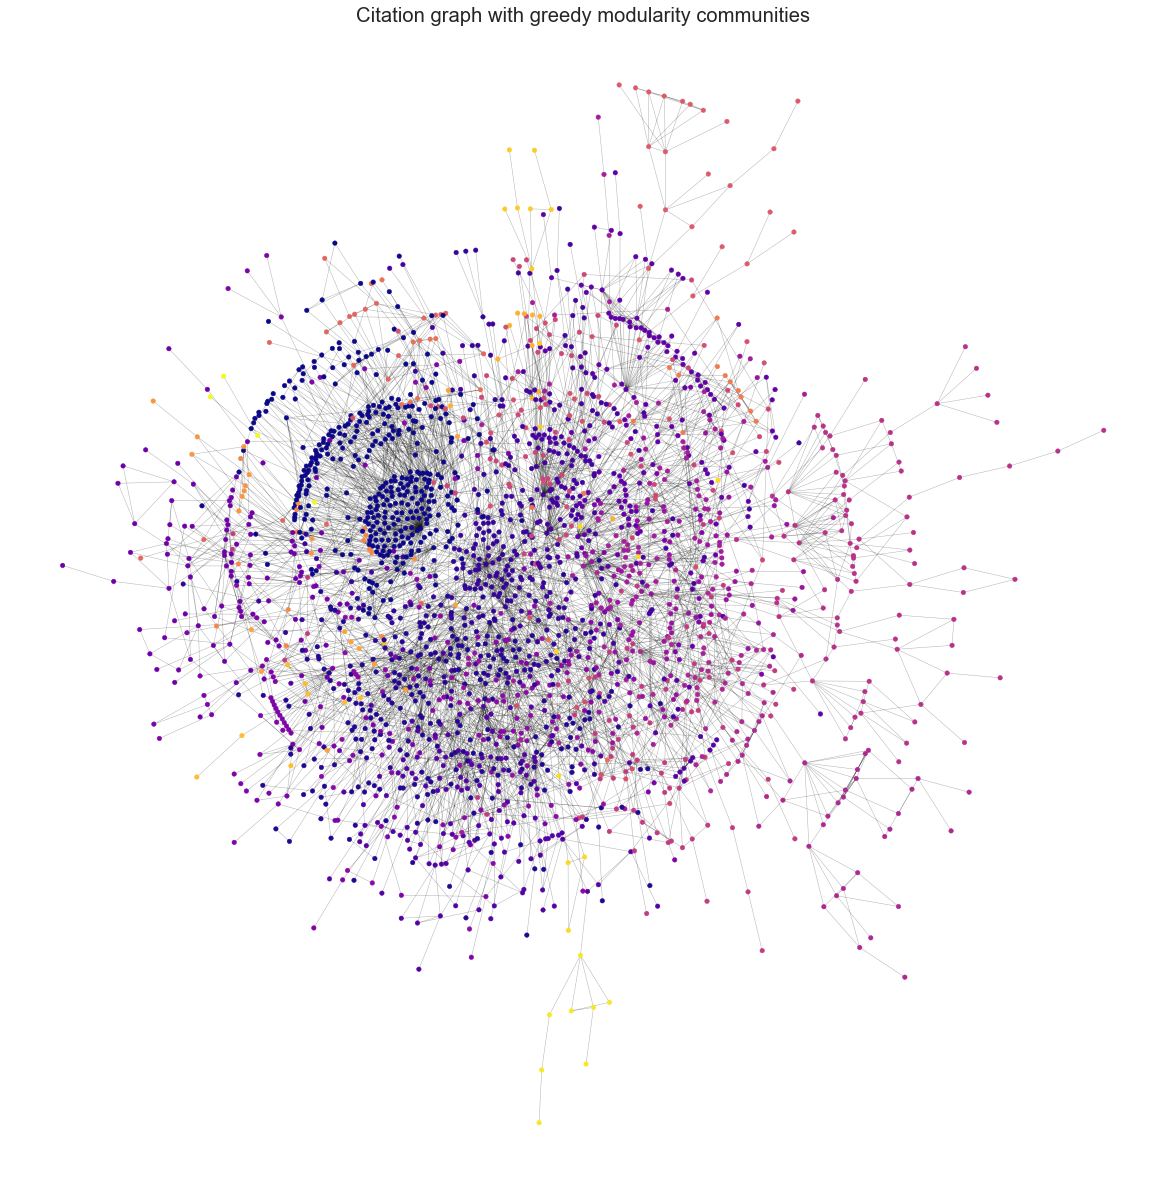

In [19]:
def getAttributeList(G, attribute):
    return list(nx.get_node_attributes(G, attribute).values())

cmapGraph = plt.cm.plasma


nx.draw(G,**kwargsGraphDraw,node_color=getAttributeList(G,"CNM Community"), cmap=cmapGraph)
plt.gcf().set_size_inches(16,16)

plt.title("Citation graph with greedy modularity communities")
plt.show()

The large number of communities makes it hard to distinguish them, as the colours are very similar. A better visualisation might be achieved by ignoring some of the communities. In any case the communities seem to fit quite well on the graph, indicationg a good division.

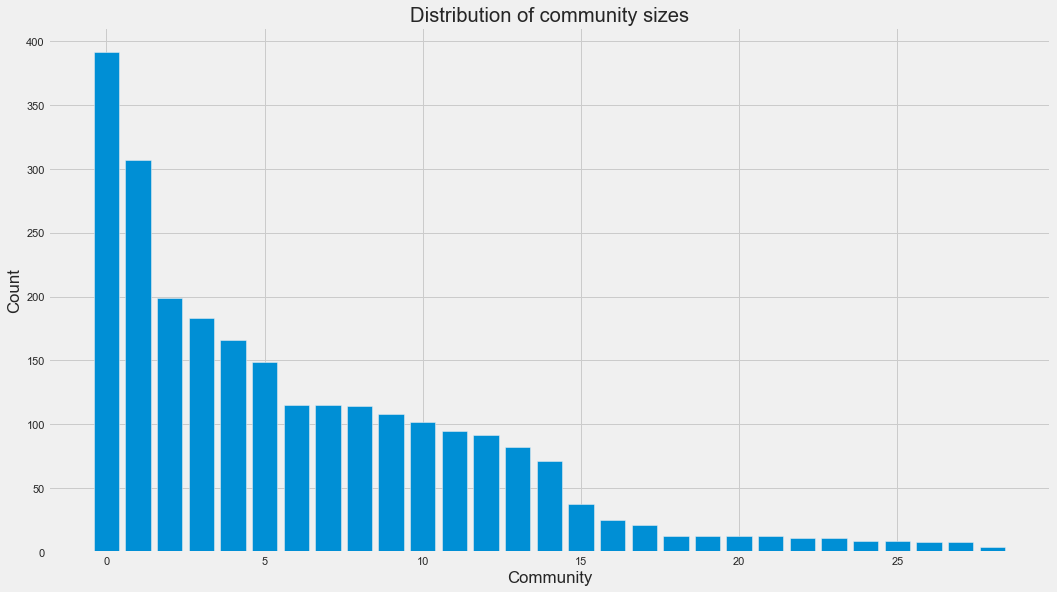

In [20]:
communitySizes = np.array(communitySizes,dtype=int)
plt.bar(list(range(len(communitySizes))),communitySizes)
plt.gcf().set_size_inches(16,9)
plt.xlabel("Community")
plt.ylabel("Count")

_ = plt.title("Distribution of community sizes")

The distribution of the community sizes is similar to that obtained in 1.1, but not as extreme. This seems to indicate a better division. Still, the large number of small communities would indicate that splitting the papers into fewer communities might be beneficial. Finally, we look at how the most important nodes are distributed among the communities.

In [21]:
for node in G.nodes(data = False):
    G.nodes[node]["degree"] = degreesDict[node]
    G.nodes[node]["pagerank"] = pageranksDict[node]

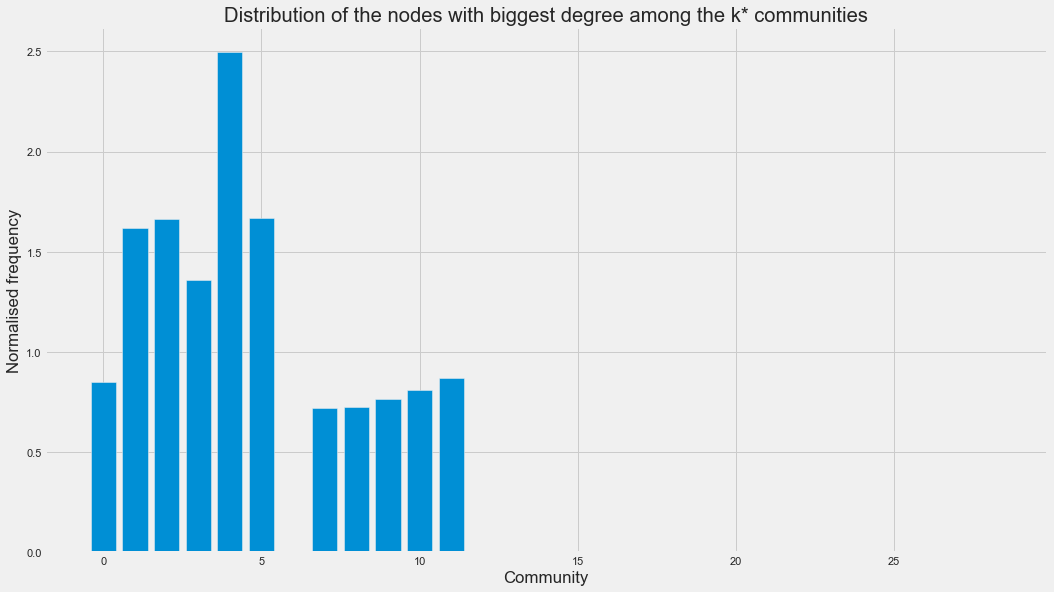

In [22]:
import scipy.stats as ss

def plotCommunityDistribution(a,title=None):
    communityDist = np.zeros(len(communitySizes))
    for nodeIndex in a:
        communityDist[G.nodes[nodeIndex]["CNM Community"]] += 1
    normalisation = communitySizes/len(G)
    
    communityDist /= normalisation*len(a)
    plt.bar(list(range(len(communityDist))),communityDist)
    plt.xlabel("Community")
    plt.ylabel("Normalised frequency")
    
    plt.title(title)
    plt.gcf().set_size_inches(16,9)
    
plotCommunityDistribution(biggestDeg, "Distribution of the nodes with biggest degree among the k* communities")

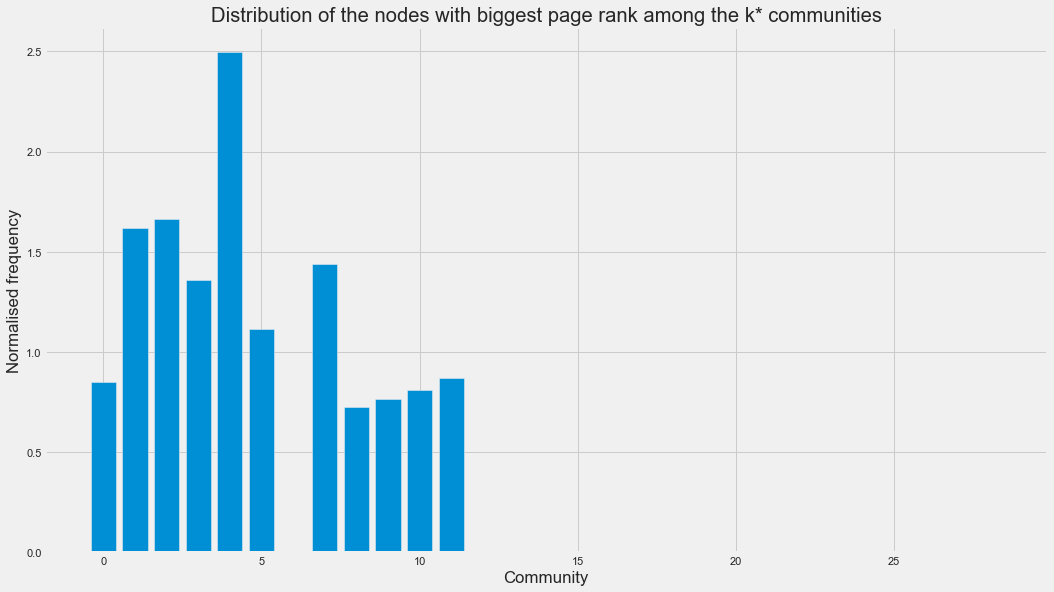

In [23]:
plotCommunityDistribution(biggestPgRnk, "Distribution of the nodes with biggest page rank among the k* communities")

The distribution is very similar between both metrics, with only one more node in community 7 at the expense of the 5th. One community has many more nodes than would be expected from random chance: the 4th one. This would be compatible with having one topic acting as a bridge between many different subjects, and so receiving citations from all of the topics it acts as a bridge to.

# Task 1.4
Mutual info and rand are both scores used to measure the similarity of two different clusterings. They are both on a scale from 0 to 1, where 0 indicates that the clusterings are completely independent of each other, and scores close to 1 indicating very similar divisions. We will use them to compare the two clusterings we have obtained in 1.1. and 1.3. We would expect them to be quite similar given that they should reveal the same underlying ground-truth (the 7 topics in the CORA dataset). However the not-so-great quality of the divisions which has been uncovered throughout, could leed to major differences.

In [24]:
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

clusterLabels = getAttributeList(G, "cluster")
communityLabels = getAttributeList(G, "CNM Community")

mi = adjusted_mutual_info_score(clusterLabels, communityLabels)
rand = adjusted_rand_score(clusterLabels, communityLabels)

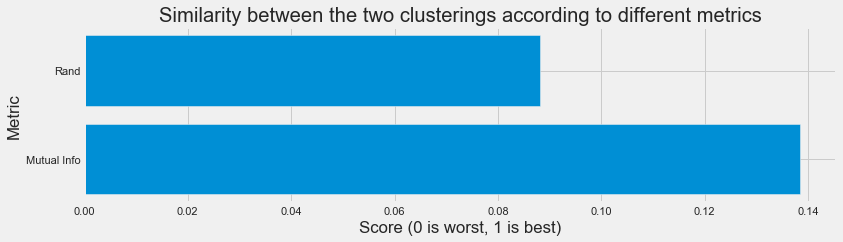

In [25]:
plt.barh(["Mutual Info", "Rand"],[mi,rand], height = 0.8)
plt.xlabel("Score (0 is worst, 1 is best)")
plt.ylabel("Metric")
plt.title("Similarity between the two clusterings according to different metrics")

plt.gca().yaxis.set_visible(True)

plt.gcf().set_size_inches(12, 3)

The scores are very low, indicating that the two methods have uncovered different characteristics, this is confirmed by looking at how the clusterings are distributed on the graph. The kmeans communities are almost randomly distributed.

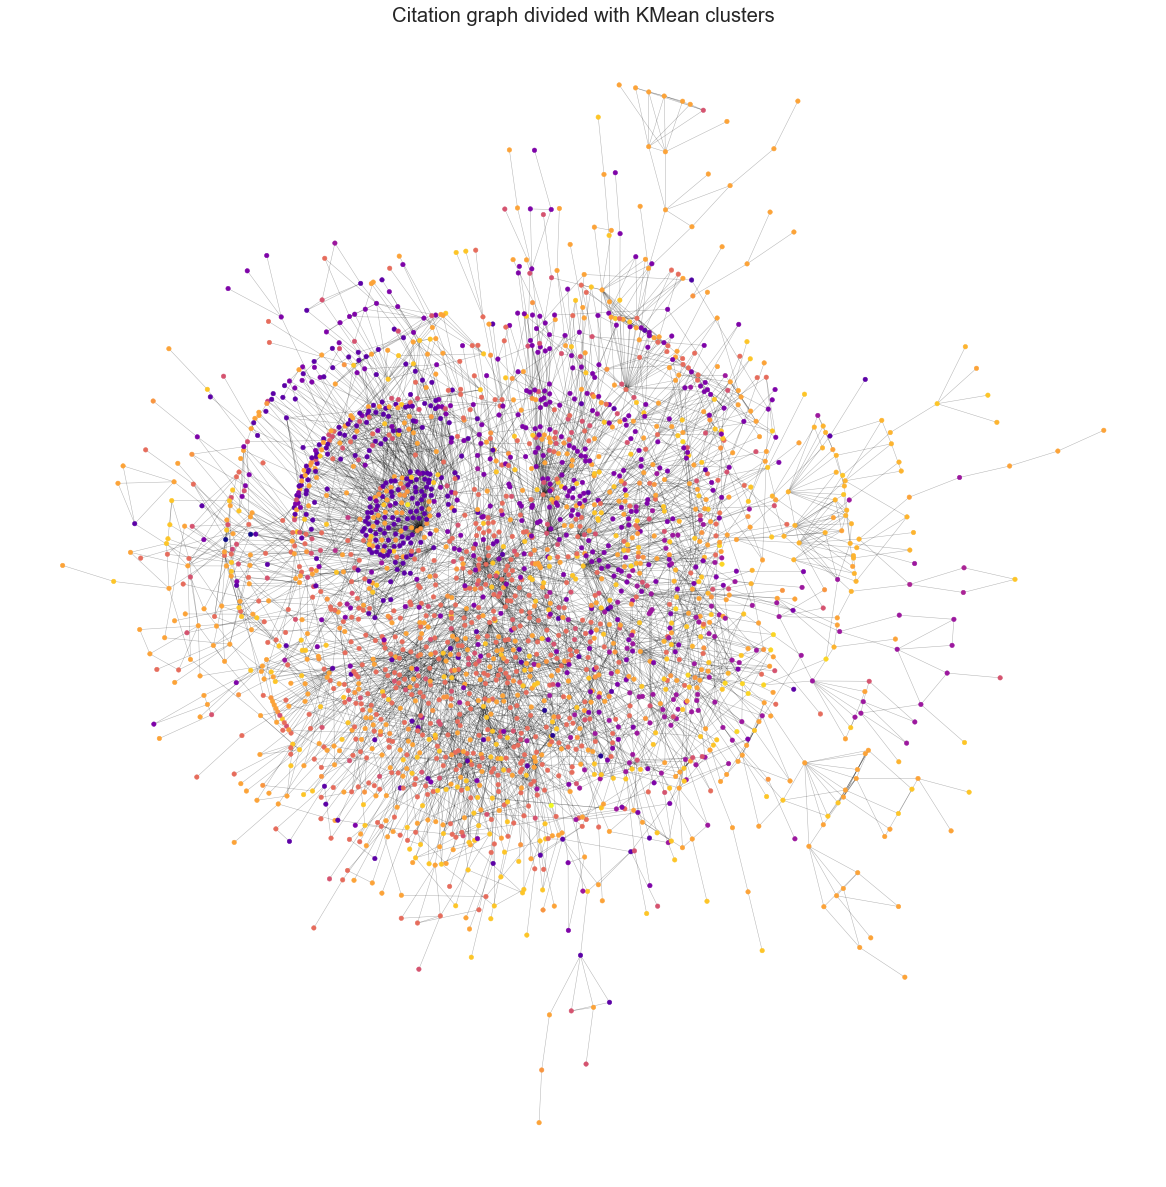

In [26]:
nx.draw(G,**kwargsGraphDraw,node_color=getAttributeList(G, "cluster"), cmap=cmapGraph)
plt.gcf().set_size_inches(16,16)

plt.title("Citation graph divided with KMean clusters")
plt.show()

We will now see how the communities found from the citation graph perform when used to divide the feature matrix.

In [27]:
def getScores(X, labels):
    """
    Returns the score according to different metrics of a clustering division on X
    """
    labels = np.array(labels)
    nLabels = len(np.unique(labels))
    X = np.array(X)
    individualDivision = [X[labels == i] for i in range(nLabels)]  #divide the papers into the unique communities
    
    #calculate the centroid of each community
    centroids = np.array([np.average(community, axis = 0) for community in individualDivision])
    return [
                calinski_harabasz_score(X, labels), 
                davies_bouldin_score(X, labels),
                dunn(X, labels, centroids),
                PBM(X, labels, centroids)
           ]

scoresClusters = getScores(featMatrix, clusterLabels)
scoresCommunities = getScores(featMatrix, communityLabels)

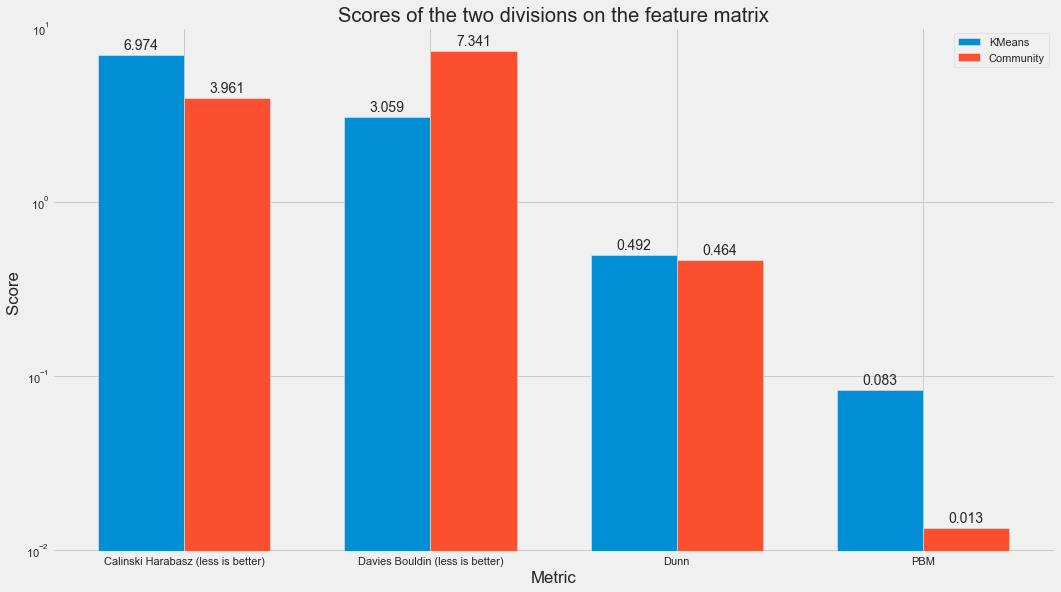

In [28]:
metricsUsed = ["Calinski Harabasz (less is better)", "Davies Bouldin (less is better)", "Dunn", "PBM"]
x = np.arange(len(scoresClusters))
width = 0.35
rects1 = plt.bar(x - width/2, scoresClusters, width, label='KMeans')
rects2 = plt.bar(x + width/2, scoresCommunities, width, label='Community')


# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel("Score ")
plt.xlabel("Metric")
plt.title("Scores of the two divisions on the feature matrix")
plt.xticks(x)
plt.gca().set_xticklabels(metricsUsed)
plt.legend()
plt.gcf().set_size_inches(16,9)

plt.yscale("log")
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate('%.3f'%height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
plt.show()

The above graph shows how the community division compares to the KMeans one when looking at the feature matrix. The KMeans division outperforms the community algorithm almost always, including by a wide margin for PBM. The one exception is the CH score, which, as mentioned before, is not a good metric for measuring the quality of the CH division. The two algorithms don't seem to capture that well the characteristics used by the other algorithm when making the division.

# Task 2
We first read in the data, split it between training and testing data, and normalise it so that it only takes values between 0 and 1. FInally we reshape it for the convolutional and linear neural networks.

In [29]:
from sklearn.datasets import fetch_openml
try:    #read files locally if available
    trainX = np.load(dataDir + "trainImg.npy").astype('float32')
    trainY = np.load(dataDir + "trainLbl.npy").astype('int64')
    testX = np.load(dataDir + "testImg.npy").astype('float32')
    testY = np.load(dataDir + "testLbl.npy").astype('int64')
except: #files don't exist and need downloading
    mnist = fetch_openml('Fashion-MNIST', cache=False)
    X = mnist.data.astype('float32')
    y = mnist.target.astype('int64')
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=10000)


trainX /= 255.0
testX /= 255.0

#flatten for MLP
trainXFlat = trainX.reshape(-1,trainX.shape[-1]**2)
testXFlat = testX.reshape(-1,testX.shape[-1]**2)

#reshape for convolutional architecture
trainXCon = trainX.reshape(trainX.shape[0],1,trainX.shape[1],trainX.shape[2])
testXCon = testX.reshape(testX.shape[0],1,testX.shape[1],testX.shape[2])

We now plot one image for each class in the dataset.

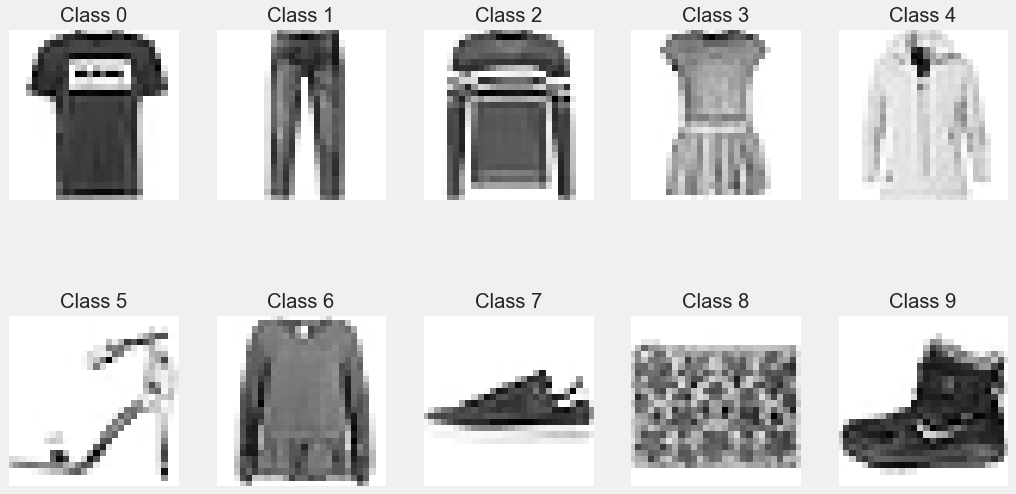

In [30]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
top = cm.get_cmap('Reds_r', 128)    #define new colormap for drawing 
bottom = cm.get_cmap('Greys', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128)))) #first half is scale of reds, second is scale of grays
mnistColours = ListedColormap(newcolors, name='SplitMNIST')

def plotImage(img, ax, allowNegatives, normaliseImage):
    """
    Plots a single image
    """
    if normaliseImage:
        vmax = 1
        vmin = -1 if allowNegatives else 0 
    else:
        vmax = max(np.amax(img),-np.amin(img))
        vmin = -vmax if allowNegatives else 0
    
    cmap = mnistColours if allowNegatives else cm.get_cmap('Greys', 128)
    
    ax.imshow(img, cmap = cmap, aspect="equal", vmin=vmin,vmax=vmax)
    
    ax.set_xticks([])
    ax.set_yticks([])
    plt.grid(False)

def plotImages(array, nrows, ncols, allowNegatives, normaliseImage = True):
    """
    Plots an array of images
    """
    f,axes = plt.subplots(nrows=nrows,ncols=ncols, sharex=True, sharey=True)

    for row in range(nrows):
        for col in range(ncols):
            plotImage(array[row*ncols + col], axes[row][col],allowNegatives, normaliseImage)
    return f,axes

def plotClasses():
    """
    Plots the first image belonging to each class in the dataset
    """
    classPos = [np.argmax(trainY == i) for i in range(10)]  #index of first image for each class in the dataset
    f,axes = plotImages(trainX[classPos],2,5,False)
    
    f.set_size_inches(16,9)
    for i in range(10):
        axes[i // 5][i % 5].set_title("Class %d"%i)
    plt.show()

plotClasses()

<a id="MNIST-classes"></a>

# Task 2.1

We start by performing kmeans clustering on the dataset. K will still be in the same range as before (\[2,30\]), however we have reduced the number of runs for each value to 10 due to long computation times. Still, this next cell will take in the order of 1-2 hours to execute. We will also record the score obtained by each division using the same 5 metrics from the fist task. We expect to see them favouring a division into 10 different clusters as that is the number of underlying classes.

In [172]:
from sklearn.cluster import MiniBatchKMeans
def evaluateLargeClusters(X, nInit=30):
    """
    Similar to evaluate clusters in 1.1, but uses mini batch KMeans, and doesn't compute
    Dunn or PBM indices for efficiency considerations.
    """
    metrics = [calinski_harabasz_score, davies_bouldin_score, silhouette_score]
    scores = np.zeros((len(metrics), 29))

    for i in range(2,31):
        model = MiniBatchKMeans(n_clusters = i, n_init = nInit, random_state = 1)
        model.fit(X)

        for j in range(len(metrics)):
            scores[j][i-2] = metrics[j](X,model.labels_)
        print("\rProgress: [%d/29]"%(i-1),end="")
    return scores

In [32]:
scoresMnist = evaluateLargeClusters(trainXFlat)

Progress: [29/29]

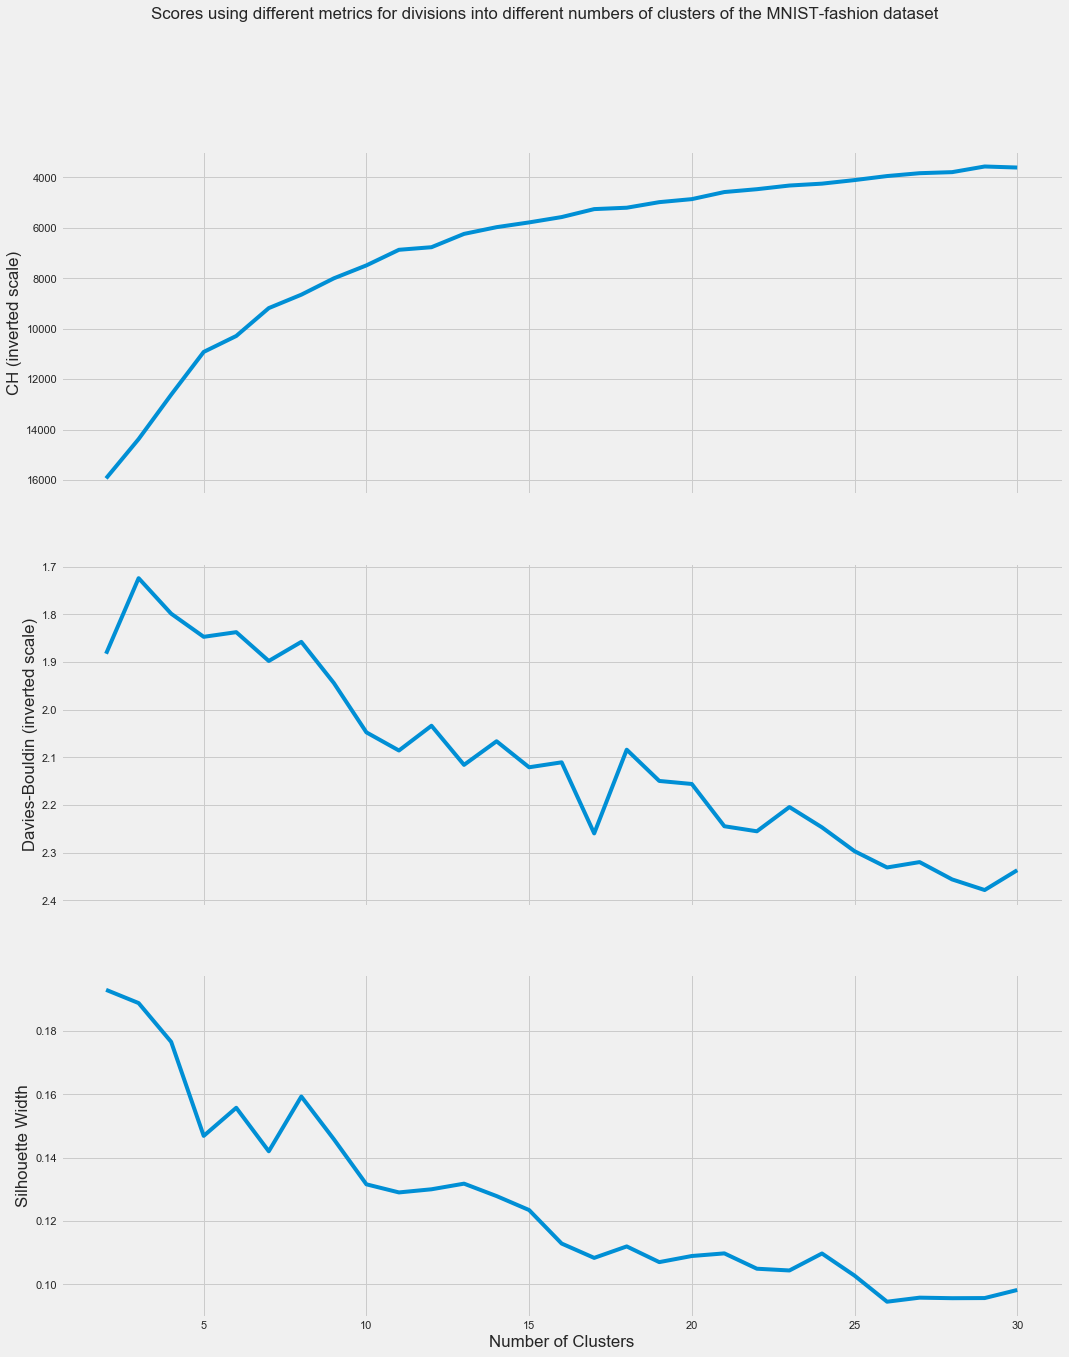

In [33]:
def plotLargeClusteringScores(scores, title):
    f, axes = plt.subplots(nrows = len(metricNames)-2, ncols = 1, sharex = True)

    for i in range(len(metricNames)-2):
        axes[i].plot(range(2,31), scores[i])
        inverted = ""

        if not isMoreBetter[i]:
            axes[i].invert_yaxis()
            inverted = " (inverted scale)"

        axes[i].set_ylabel(metricNames[i]+inverted)
    f.set_size_inches(16,20)
    axes[-1].set_xlabel("Number of Clusters")
    f.suptitle(title)
plotLargeClusteringScores(scoresMnist, "Scores using different metrics for divisions into different numbers of clusters of the MNIST-fashion dataset")

Dunn and PBM indeces weren't computed, as they would increase exceedingly the already very long computation time required. However during development they showed similar results to those of the methods above, seemingly only indicating that fewer clusters are better.

Even though there doesn't to seem any indication of 10 being the ideal number of clusters, we know that that is the correct number of ground truth classes. We therefore train our model with k = 10.

In [173]:
mnistModel = MiniBatchKMeans(n_clusters = 10, n_init = 100, random_state = 1)
_ = mnistModel.fit(trainXFlat)

We must take some care before using our predictions as a kNN classifier: as KMeans is an unsupervised method, it has no way to know which cluster corresponds to each label. Theoretically we could be in the situation where all of the classes have been correctly clustered together, but with the wrong labels, resulting in an apparent precision of 0%. To avoid this, we compute the confusion matrix, and swap the labels to achieve the highest value for the trace. 

Another way to interpret the task, would be to greedily assign each cluster to the label which maximises the accuracy, possibly making it so that some of the ground-truth classes are never predicted by the model. However, in practice the two methods give very similar results, and we only get a increase of a few percentage points in the overall accuracy using this method, in particular, in this case we would only have one class change its label, and even then the increase in accuracy is of only 3 percentage points. For simplicity we will stick to our current method, noting that the discussion would be similar either way.

In [35]:
from sklearn.metrics import confusion_matrix, classification_report

def getBestLabels(labelsTrue, labelsPredicted):
    cost = -confusion_matrix(labelsTrue, labelsPredicted)   
    #we take the negative of the confusion matrix as the algorithm minimises, rather than maximises, the value of the trace
    _, bestArrangement = scipy.optimize.linear_sum_assignment(cost)

    return bestArrangement

def relabel(labelsPredicted, arrangement):
    """
    Rearranges the values of labelsPredicted. Arrangement should be an array of length
    nClasses which should contain in the i-th position the new label for class i. For 
    example, if one wishes to swap classes 0 and 1 in labelsPredicted and keep the rest
    unchanged, arrangement should be [1,0,2,3,...]
    """
    nLabels = len(np.unique(labelsPredicted))
    bestLabels = np.zeros(labelsPredicted.shape, dtype = int)

    for i in range(nLabels):
        bestLabels[labelsPredicted == arrangement[i]] = i
    
    return bestLabels

prediction = mnistModel.predict(trainXFlat)     #assigns to each point the class corresponding to the closest centroid
arrangement = getBestLabels(trainY, mnistModel.labels_)     #Compute the best ordering of the classes

prediction = relabel(prediction, arrangement)   #update the predictions with the correct relabeling

We can now compare the centroids to representatives of each class in our dataset, this should give us an idea of how well our model might perform.

In [36]:
individualClasses = np.array([trainXFlat[trainY == i] for i in range(10)])
#divides the dataset into the ten unique classes

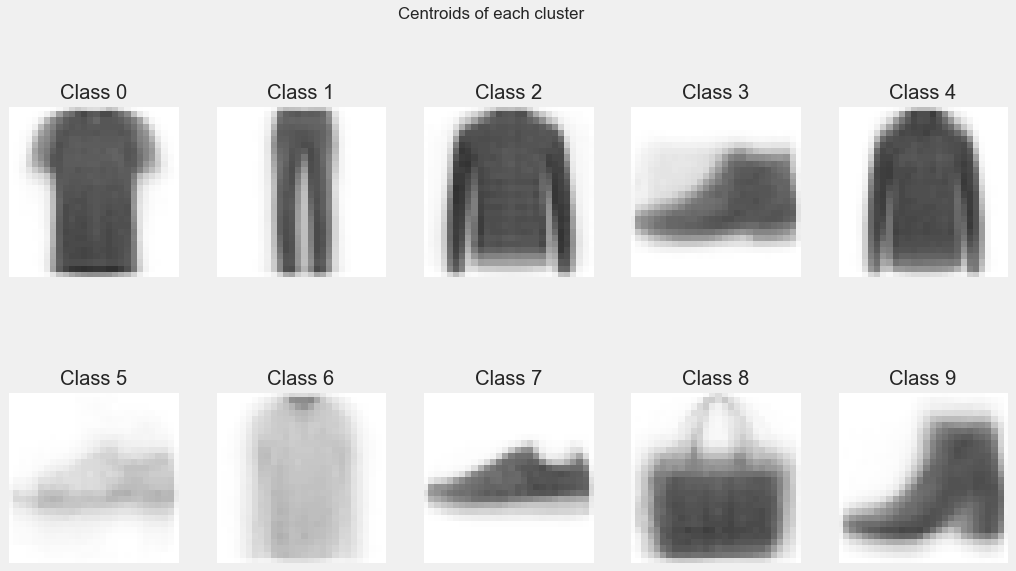

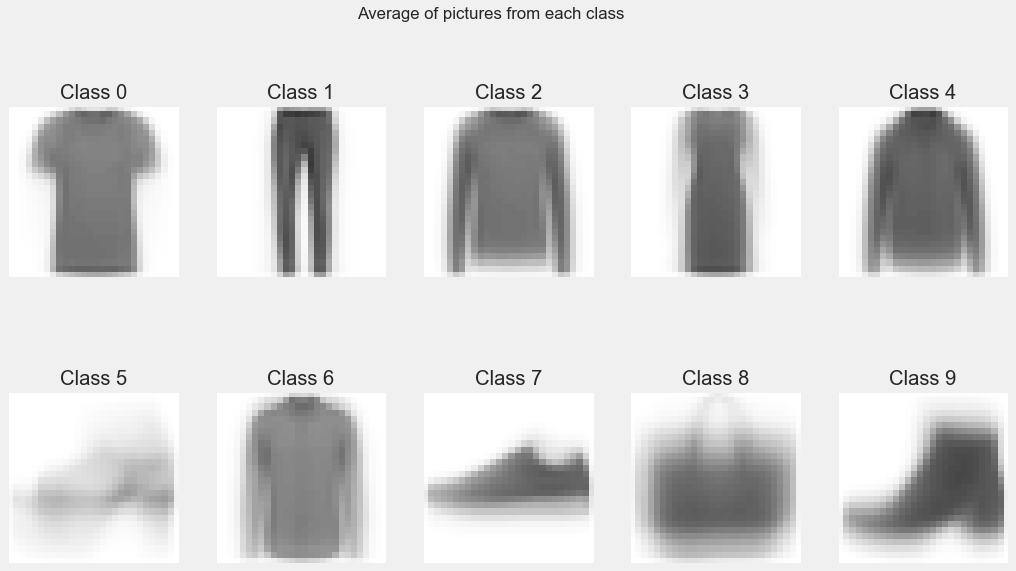

In [96]:
mnistCentroids = mnistModel.cluster_centers_.reshape(-1,28,28)
f, axes = plotImages(mnistCentroids,2,5,False)      #plot the centroids
f.set_size_inches(16,9)
f.suptitle("Centroids of each cluster")

f,axes2 = plotImages(np.average(individualClasses,axis=1).reshape(-1,28,28),2,5,False)
f.set_size_inches(16,9)
f.suptitle("Average of pictures from each class")

axesPositions = [0]*10
for i in range(10):
    axes[arrangement[i] // 5][arrangement[i] % 5].set_title("Class %d"%i)
    axes2[i//5][i%5].set_title("Class %d"%i)

    axesPositions[i] = axes[i // 5][i % 5].get_position()

for i in range(10): #order the images to be able to compare them to the actual classes easier.
    axes[arrangement[i] // 5][arrangement[i] % 5].set_position(axesPositions[i])

<a id="centres"></a>
The above images suggest that the unsupervised kmeans method has performed surprisingly well. The main problem being that it has split the shoes into 4 rather than 3 classes, at the expense of the dress class. All of the other images look remarkably similar, though, with the exception of class 6 which sees the opposite happen, the centroids of the cluster are darker. We thus expect the model to perform extremely poorly on class 3 and quite well on the others, though many of the upper body garments might get confused, in particular the lighter coloured ones might get wrongly classified as belonging to class 6. We train a kNN classifier using our prediction for the training data, and use it to predict the labels for the test data. We could also have used the centroids of each cluster to train a 1-Nearest Neighbour classifier, however doing it this way gives us slightly better accuracy, as the algorithm performs better on the edges.

In [38]:
from sklearn.neighbors import KNeighborsClassifier

kNNMnist = KNeighborsClassifier(n_jobs=-1)
kNNMnist.fit(trainXFlat, prediction)

testPrediction = kNNMnist.predict(testXFlat)

In [39]:
from sklearn.metrics import precision_score, accuracy_score

def getClassificationScores(prediction):
    return [precision_score(testY, prediction,average="weighted"), accuracy_score(testY, prediction)]
dfClassificationScores = pd.DataFrame(columns = ["Method", "Precision", "Accuracy"])

In [40]:
print("."+classification_report(testY, testPrediction))
dfClassificationScores.loc[0] =(["KMeans"] + getClassificationScores(testPrediction))

.              precision    recall  f1-score   support

           0       0.56      0.61      0.59      1000
           1       0.57      0.90      0.70      1000
           2       0.40      0.46      0.43      1000
           3       0.00      0.00      0.00      1000
           4       0.51      0.41      0.45      1000
           5       0.75      0.81      0.78      1000
           6       0.25      0.40      0.31      1000
           7       0.88      0.67      0.76      1000
           8       0.99      0.42      0.59      1000
           9       0.90      0.63      0.74      1000

    accuracy                           0.53     10000
   macro avg       0.58      0.53      0.53     10000
weighted avg       0.58      0.53      0.53     10000



As expected, the model performs terribly on class 3 and quite well on the other. There is however some big variation: for example, class 8 (bags), has an incredible high precision but low recall, indicating that the cluster only covers a subset of the real class. On the other hand, class 1 has high recall but low precision, indicating a cluster which is too big and includes pictures from other classes. The confusion matrix can let us see which classes have been mixed up.

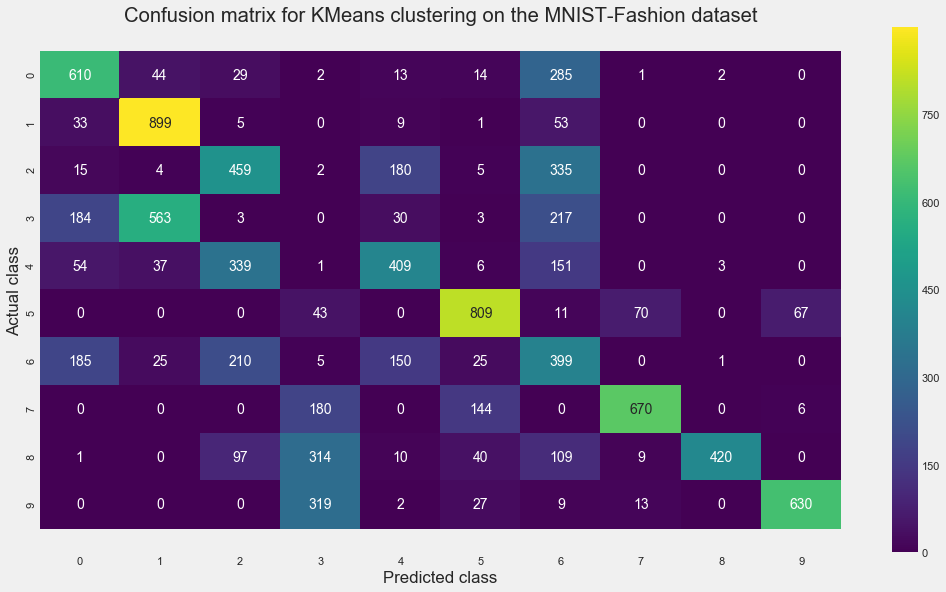

In [41]:
def plotConfusionMatrix(realLabel, predictedLabel, title = ""):
    sns.heatmap(confusion_matrix(realLabel, predictedLabel), cmap="viridis", annot=True,fmt="g")
    plt.xlabel("Predicted class")
    plt.ylabel("Actual class")
    plt.title(title)
    plt.gcf().set_size_inches(16,9)
    plt.gca().set_ylim(len(np.unique(realLabel))+0.5, -0.5)
    plt.show()

plotConfusionMatrix(testY, testPrediction, "Confusion matrix for KMeans clustering on the MNIST-Fashion dataset")

The confusion matrix more clearly shows some of the trends we suggested: for example the predicted class 1 is in reality class 1 and a good part of the missing class 3: the kmeans model wasn't able to differentiate between dresses and trousers.  As expected class 6 seems to represent all light-coloured upper-body garments rather than just shirts. While class 3 seems to contain both boots and bags. Overall, kmeans seems to have performed better than might be expected in this task, but a supervised method might work better on this classification task, the next figure helps explain why this might be the case.

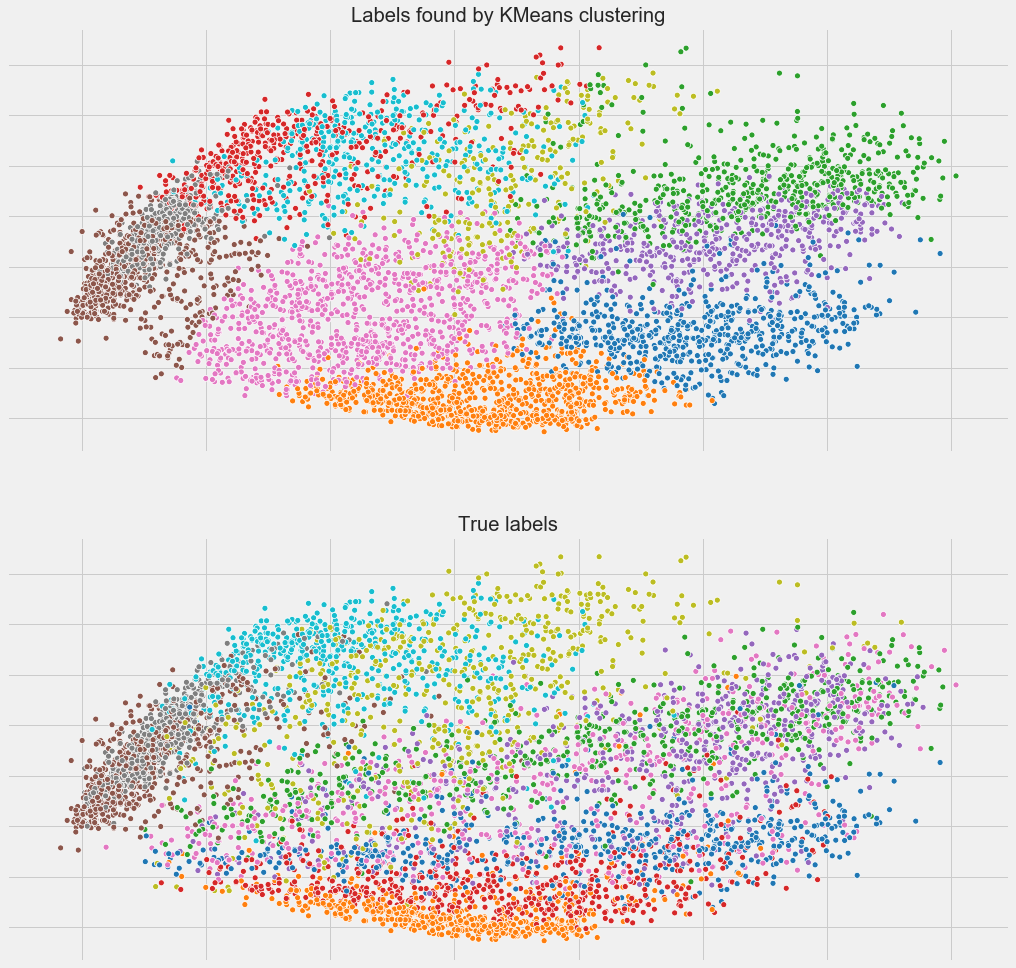

In [42]:
from sklearn.decomposition import PCA

#use PCA to project the data on the 2 most important directions
projected = PCA(n_components = 2).fit_transform(trainXFlat)  
df = pd.DataFrame(columns = ["x","y"],data = projected)
df["labelPred"] = prediction
df["labelTrue"] = trainY

f, (ax1,ax2) = plt.subplots(nrows = 2,ncols = 1, sharex = True)
frequency = 10
sns.scatterplot(x="x",y="y",hue="labelPred",data=df.iloc[::frequency],palette="tab10",ax=ax1)
ax1.set_title("Labels found by KMeans clustering")
ax1.get_legend().remove()
ax1.set_xticklabels(['']*len(ax1.get_xticklabels()))
ax1.set_yticklabels(['']*len(ax1.get_yticklabels()))
ax1.set_ylabel(None)
ax1.set_xlabel(None)


sns.scatterplot(x="x",y="y",hue="labelTrue",data=df.iloc[::frequency],palette="tab10",ax=ax2)
ax2.set_title("True labels")
ax2.get_legend().remove()
ax2.set_xticklabels(['']*len(ax2.get_xticklabels()))
ax2.set_yticklabels(['']*len(ax2.get_yticklabels()))
ax2.set_ylabel(None)
ax2.set_xlabel(None)

f.set_size_inches(16,16)
plt.show()

<a id="PCA"></a>The data is 784 dimensional, which is clearly too many to properly visualise. Using PCA decomposition we are able to find the two most important directions, project our data onto them, and plot it. This clearly shows the problem with the unsupervised approach: it has done a great job at dividing the data into clusters, but the real data isn't neetly divided in pixel space and so an unsupervised method will always fail to correctly label the data. 

The ground truths represent the usage of a certain item, not necessarily the way it looks, so two images which might be similar, say a light coloured shirt and tshirt, can have different labels; while two images which look quite different, like a black and white shirt, might belong to the same category.

# Task 2.2

We first setup the classes which will be common to all neural networks used. These are the same as in Coursework 2 except for minor changes, due to the slightly different structure of the data.

In [43]:
import torch
import torch.nn as nn

useCuda = torch.cuda.is_available()

class NNDatasetFlat(torch.utils.data.Dataset):
    '''
    Class to store the datasets for the neural networks
    '''
    def __init__(self,X,y):
        #convert data to PyTorch tensors
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
        
        #transfer data to VRAM
        if useCuda:
            self.X = self.X.cuda()
            self.y = self.y.cuda()
    
    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self,index):
        return self.X[index],self.y[index]

In [44]:
class NNBase(nn.Module):
    '''
    Basic class from which all neural networks are inherited
    This is an abstract class which cannot be instantiated
    '''
    def __init__(self,learningRate, batchSize, verbose, validate, epochs, criterion, optimiser= torch.optim.SGD):
        super(NNBase,self).__init__()
        self.criterion = criterion
        self.learningRate = learningRate
        self.batchSize = batchSize
        self.verbose = verbose
        self.validate = validate
        self.epochs = epochs
        self.optimiser = optimiser
    
    @staticmethod
    def forward(self, X):
        pass

    def reset(self):
        '''
        Resets all parameters in the network, useful if training the same network
        more than once on different datasets
        '''
        def resetWeight(m):
            if isinstance(m, nn.Linear):
                m.reset_parameters()
        self.apply(resetWeight)

    def fit(self, X, y):
        '''
        Train the network on the dataset X with labels y
        Returns in-sample and out-of-sample loss during training
        '''
        validate = self.validate    #wether to reserve some of the data for validation
        dataset = NNDatasetFlat(X,y)

        #split the dataset into validation and training if required otherwise only use training
        if validate:
            trainSize = int(0.8 * len(dataset))
            validationSize = len(dataset) - trainSize
            trainDataset, validationDataset = torch.utils.data.random_split(dataset, [trainSize, validationSize])
        else:
            trainSize = len(dataset)
            trainDataset = dataset
        self.train()        #put network in training mode, necessary to activate the dropout layers
        self.reset()        #reset all weights

        if useCuda: #compute on GPU
            self.cuda()

        optimiser = self.optimiser(self.parameters(),lr=self.learningRate)
        loader = torch.utils.data.DataLoader(dataset=trainDataset,batch_size=self.batchSize,shuffle=True)

        #I know this is not the right way to do this but the efficiency loss is negligible 
        if validate:
            loaderValidation = torch.utils.data.DataLoader(dataset=validationDataset,
                                                            batch_size=validationSize,
                                                            shuffle=False
                                )
            
            xVal, yVal = next(iter(loaderValidation))   
            #get all of the valiudation data (note that the batch size is the same as the dataset size)

        lossTrain = []
        lossValidation = []

        for epoch in range(self.epochs):
            currLoss = 0.0
            for pixels, classes in loader:
                optimiser.zero_grad()   #the optimiser will have the values from the previous iteration, so it needs to be reset
                outputs = self(pixels)  #apply the neural network to the predictors to get predicted ratings
                loss = self.criterion(outputs, classes) #calculate the loss

                loss.backward()  #calculate the derivative of the loss
                optimiser.step()  #update weights

                currLoss += loss.item() * pixels.size(0)    #save the current loss, we multiply by the size of the batch to normalise
            lossTrain.append(currLoss/trainSize)        #divide by the total number of elements in the training dataset
            if validate:    #calculate the loss on the validation dataset
                outputsVal = self(xVal)
                loss = self.criterion(outputsVal,yVal)
                lossValidation.append(loss.item())
                
            if self.verbose:
                print('\rEpoch [%d/%d]'%(epoch+1, self.epochs),end='')

        if validate:
            return lossTrain, lossValidation
        return lossTrain
    
    def predict(self, X):
        self.eval()     #deactivate the dropout layer
        x = torch.from_numpy(X).float()  #convert X to a PyTorch tensor
        if useCuda:
            x = x.cuda()
        y = self(x).cpu().detach().numpy().argmax(axis=1)   #convert y into a numpy array, then find the maximum value and return its index, as the index corresponds exactly to the rating this will return the highest probability class
        return y

# Task 2.2.1

Given the object oriented paradigm used, we now only need to specify the forward method for the network.

In [45]:
class MLP(NNBase):
    def __init__(self, 
                 learningRate=5e-3, 
                 batchSize=128, 
                 verbose=True, 
                 validate = True, 
                 epochs = 30, 
                 criterion = nn.NLLLoss()
                ):
        super(MLP, self).__init__(learningRate, batchSize, verbose, validate, epochs, criterion)
        N_PIXELS = trainXFlat.shape[1]
        N_CLASSES = 10
        N_HIDDEN = 100
        self.layerIn = nn.Linear(N_PIXELS, N_HIDDEN)
        self.layerHidden = nn.Linear(N_HIDDEN, N_HIDDEN)
        self.layerOut = nn.Linear(N_HIDDEN, N_CLASSES)
        self.activation = nn.ReLU()
        self.final = nn.Softmax()
    
    def forward(self, x):
        out = self.layerIn(x)
        out = self.activation(out)
        out = self.layerHidden(out)
        out = self.activation(out)
        out = self.layerHidden(out)
        out = self.activation(out)
        out = self.layerOut(out)
        return self.final(out)

In [46]:
mlp = MLP()
useCuda = True
#use GPU to accelerate if available
if useCuda:
    mlp.cuda()

lossMLP,lossMLPVal = mlp.fit(trainXFlat,trainY) #train network using X as predictor and y as labels

Epoch [30/30]

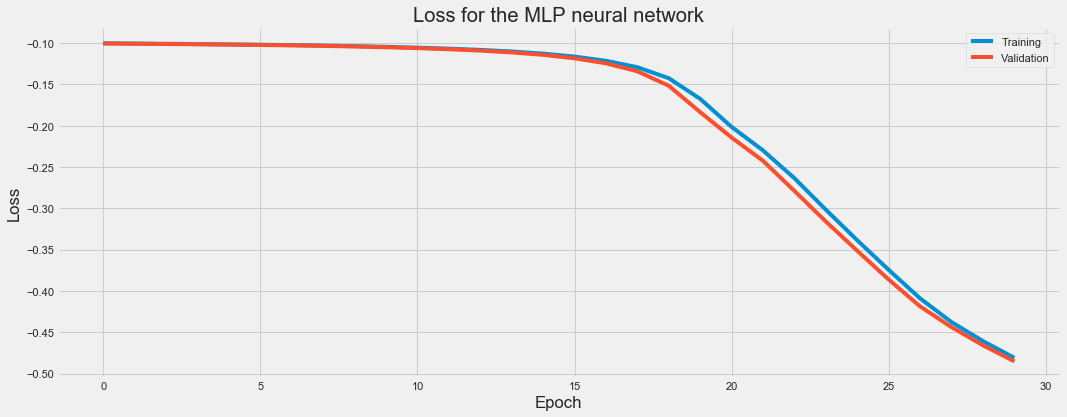

In [47]:
def plotLossNN(loss, lossVal, title=""):
    plt.plot(loss, label="Training")
    plt.plot(lossVal, label="Validation")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.gcf().set_size_inches(16,6)
    plt.show()

plotLossNN(lossMLP,lossMLPVal, "Loss for the MLP neural network")

The plots for the validation and training loss clearly show that no over-fitting has occurred, and that the netwrok could have used a longer training time. Thus we suspect that it won't have fully converged.

In [48]:
predictionMLP = mlp.predict(testXFlat)
print(classification_report(testY, predictionMLP))

              precision    recall  f1-score   support

           0       0.45      0.86      0.59      1000
           1       0.64      0.92      0.75      1000
           2       0.36      0.94      0.52      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.60      0.80      0.68      1000
           8       0.82      0.93      0.87      1000
           9       0.61      0.96      0.75      1000

    accuracy                           0.54     10000
   macro avg       0.35      0.54      0.42     10000
weighted avg       0.35      0.54      0.42     10000



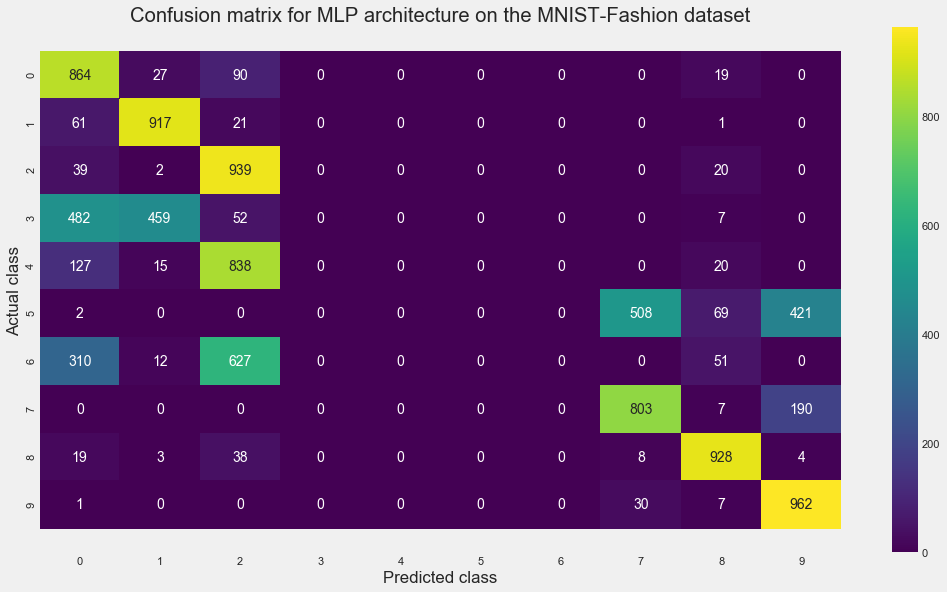

In [49]:
plotConfusionMatrix(testY, predictionMLP, "Confusion matrix for MLP architecture on the MNIST-Fashion dataset")

The confusion matrix and the report confirm the suspicion, with the network managing to categorise only a few of the class (getting good recall on them), while never predicting most of them. Comparing it to the 10-Means classifier is probably not going to be very useuful, it would make more sense to compare it to a 6-means classifier. 

# Task 2.2.2

In [50]:
class CNN(NNBase):
    def __init__(self, 
                 learningRate=5e-3, 
                 batchSize=128, 
                 verbose=True, 
                 validate = True, 
                 epochs = 30, 
                 criterion = nn.NLLLoss()
                ):
        
        super(CNN, self).__init__(learningRate, batchSize, verbose, validate, epochs, criterion)
        kwargsConv = {"kernel_size": 5,"stride":1,"dilation":1}

        self.conv1 = nn.Sequential(
            nn.Conv2d(1,6,**kwargsConv),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(6,16,**kwargsConv),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2)
        )

        self.layerOut = nn.Sequential(
            nn.Linear(16*4*4,120),
            nn.ReLU(),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,10)
        )

        self.final = nn.Softmax()
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.view(out.size(0), -1)
        out = self.layerOut(out)
        return self.final(out)

In [51]:
cnn = CNN()
#useCuda = False
#use GPU to accelerate if available
if useCuda:
    cnn.cuda()

lossCNN,lossCNNVal = cnn.fit(trainXCon,trainY) #train network using X as predictor and y as labels

Epoch [30/30]

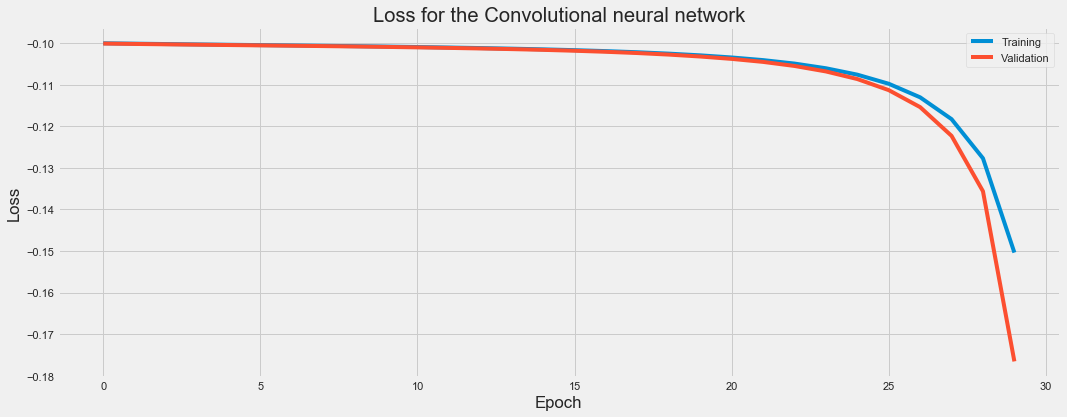

In [52]:
plotLossNN(lossCNN, lossCNNVal, "Loss for the Convolutional neural network")

As before the loss indicates that the network needs more training time. Looking at the absolute value and comparing it to the one of the previous network, we can see that little training has hapenned at all, and the network is probably very similar to the dummy classifier which classifies everything as belonging to one class.

In [53]:
predictionCNN = cnn.predict(testXCon)

print(classification_report(testY, predictionCNN))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.97      0.63      0.76      1000
           2       0.00      0.00      0.00      1000
           3       0.82      0.34      0.48      1000
           4       0.17      1.00      0.28      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.61      0.65      0.63      1000
           8       0.82      0.04      0.07      1000
           9       0.54      0.97      0.69      1000

    accuracy                           0.36     10000
   macro avg       0.39      0.36      0.29     10000
weighted avg       0.39      0.36      0.29     10000



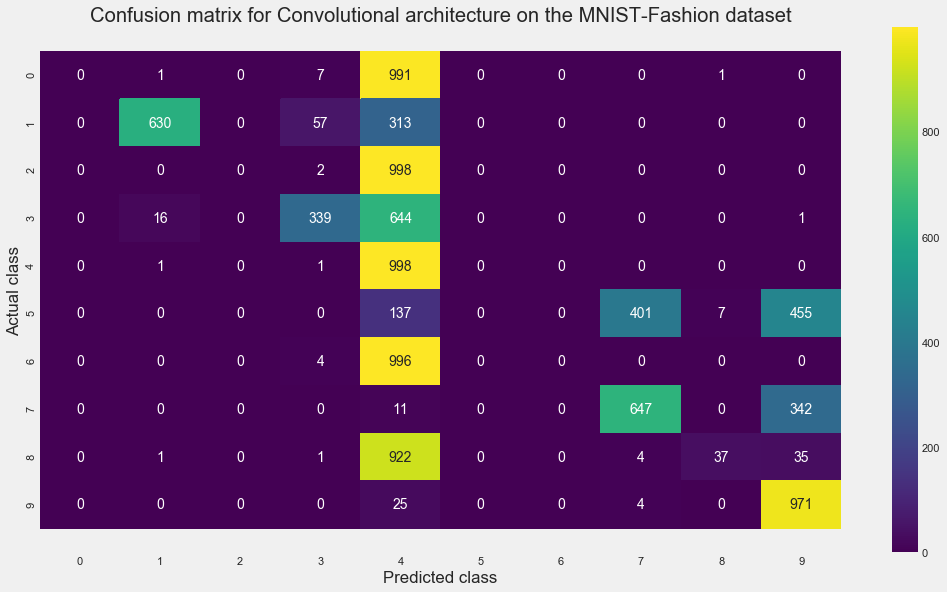

In [54]:
plotConfusionMatrix(testY, predictionCNN, "Confusion matrix for Convolutional architecture on the MNIST-Fashion dataset")

Once again, we clearly see that the network needs a longer training time, and little can be said on the valiity of the approach without it. The network has only managed to distinguish between a few of the classes, and is only starting to learn a few more.

# Task 2.2.3
We first compare the two different neural networks. As mentioned before, both architectures clearly need more training time, so this discussion won't focus on the specifics but on the theoretical advantages and disadvantages. Convolutional neural networks have been shown to perform much better than fully connected MLP architectures, [8](#references), this is mainly due to the ability to better retain some of the structure of the images. The current state-of-the-art classifier [9](#references), uses the EfficientNet model [10](#references) which uses Convolutional layers as its basic unit.

Another advantage is the reduced number of parameters needed to achieve the same accuracy. Compare the number of parameters for our two networks.

In [55]:
def getNParams(model):
    return np.sum(np.prod(p.size()) for p in model.parameters())

print("Number of parameters for the MLP: %d\nNumber of parameters for the CNN: %d"%(getNParams(mlp),getNParams(cnn)))

Number of parameters for the MLP: 89610
Number of parameters for the CNN: 44426


This helps reduce latency while also giving less over-fitting as might happen from the greater freedom given by a larger number of parameters (though the last problem can be alleviated by introducing dropout layers). We suspect that both are much more adequate than KMeans for the task at hand. MLP already performs slightly better even though all indications are that more time is needed for training, and we know that convolutional networks perform even better in image-classification tasks. To better compare the potential of the two methods we give the MLP and CNN more epochs to train.

In [56]:
mlpLong = MLP(epochs=90)
if useCuda:
    mlpLong.cuda()

mlpLL, mlpLLVal = mlpLong.fit(trainXFlat,trainY) #train network using X as predictor and y as labels

Epoch [90/90]

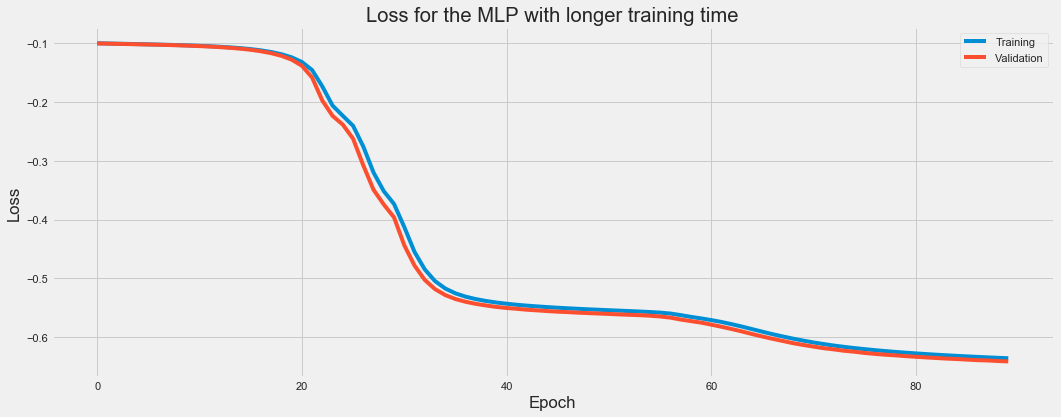

In [57]:
plotLossNN(mlpLL, mlpLLVal, "Loss for the MLP with longer training time")

In [58]:
predictionMLPLong = mlpLong.predict(testXFlat)

print(classification_report(testY, predictionMLPLong))
dfClassificationScores.loc[1] =(["MLP"] + getClassificationScores(predictionMLPLong))

              precision    recall  f1-score   support

           0       0.44      0.94      0.60      1000
           1       0.81      0.94      0.87      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.37      0.96      0.53      1000
           5       0.92      0.85      0.89      1000
           6       0.00      0.00      0.00      1000
           7       0.88      0.89      0.88      1000
           8       0.86      0.94      0.90      1000
           9       0.86      0.93      0.89      1000

    accuracy                           0.65     10000
   macro avg       0.51      0.65      0.56     10000
weighted avg       0.51      0.65      0.56     10000



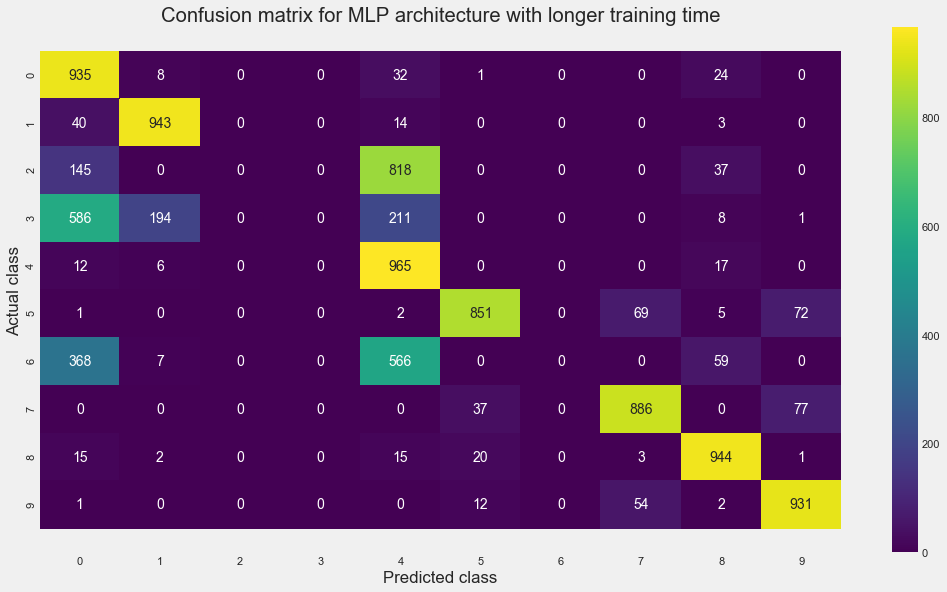

In [59]:
plotConfusionMatrix(testY, predictionMLPLong, "Confusion matrix for MLP architecture with longer training time")

In [60]:
cnnLong = CNN(epochs=90, validate=True)
if useCuda:
    cnnLong.cuda()

cnnLL, cnnLLVal = cnnLong.fit(trainXCon,trainY) #train network using X as predictor and y as labels

Epoch [90/90]

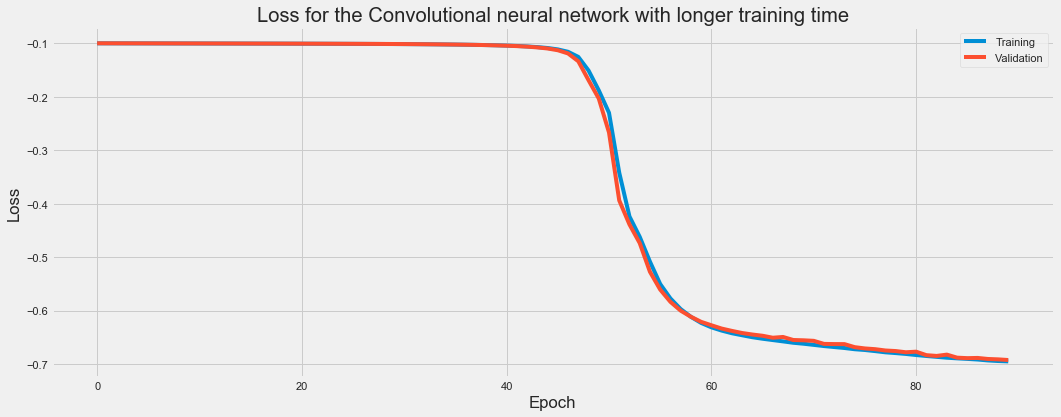

In [61]:
plotLossNN(cnnLL, cnnLLVal, "Loss for the Convolutional neural network with longer training time")

In [62]:
predictionCNNLong = cnnLong.predict(testXCon)

print(classification_report(testY, predictionCNNLong))
dfClassificationScores.loc[2] =(["CNN"] + getClassificationScores(predictionCNNLong))

              precision    recall  f1-score   support

           0       0.68      0.77      0.72      1000
           1       0.92      0.91      0.91      1000
           2       0.00      0.00      0.00      1000
           3       0.71      0.80      0.76      1000
           4       0.37      0.89      0.52      1000
           5       0.92      0.87      0.89      1000
           6       0.00      0.00      0.00      1000
           7       0.85      0.88      0.86      1000
           8       0.73      0.96      0.83      1000
           9       0.89      0.92      0.90      1000

    accuracy                           0.70     10000
   macro avg       0.61      0.70      0.64     10000
weighted avg       0.61      0.70      0.64     10000



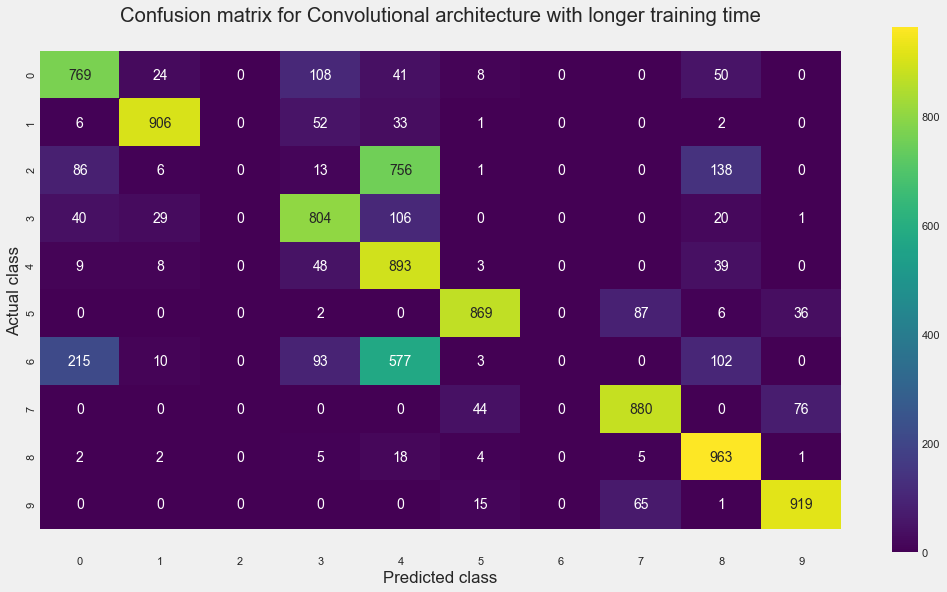

In [63]:
plotConfusionMatrix(testY, predictionCNNLong, "Confusion matrix for Convolutional architecture with longer training time")

The increased number of epochs has benefitted both network architectures. However they are still very conservative in their guesses: only ever prediciting labels as belonging to a particular class once it is confident it can distinguish them from the others. This results in recalls which are either 0 or above 80%. It is hard to train away from these local minima: if a network were to devuate from them, it would at first incurr a biug loss in accuracy since it would lack the ability to distinguish subtl differences between the classes, so at first it would simply mislabel items which it had previously correctly identified. This can also be seen on the loss graph: with long stationary periods followed by short periods in which the networks learn to distinguish between certain classes, greatly increasing the accuracy. However, the two nets seem to have reached some sort of limit in their ability to correctly label the images: more time wouldn't result in them being able to separate out the remaining classes. As the CNN is performing worse than the MLP, contrary to what the literature suggests, we should be able to increase the accuracy of the CNN by slightly tweaking its architecture. The state-of-the-art image classifier manages to correctly classify an image 88.4% of the time out of a possible 1000 labels, [9](#references). Given the much simpler task at hand, we expect to be able to achieve a similar accuracy on our task.

On the other hand, the unsupervised classification method has severe limitations and can never hope to achieve that high of an accuracy: the images will always have some arbitrary features which make it impossible for a fully unsupervised method to achieve much higher precision. The methods becomes even less usable once images which aren't neetly cropped and correctly rotated are used. After all, "distance in pixel space", which is the metric used by kmeans, is not really a good metric to evaluate how similar two images are: consider the case of a picture of a shoe flipped vertically. To a human the resulting photo would clearly be very similar to the original, but the same can't be said for their "distance in pixel space", which could be very high. A neural network could be taught to ignore the difference by being given both images during training, however an unsupervised method can't hope for such a simple solution. The biggest advantage of unsupervised methods (not needing already classified data) is also becoming less relevant as there are many resources containing well-organised data online. 

## Improving performance of the CNN
We now focus on trying to bring the predictive power of the CNN more in line with our expectations by tweaking the architecture.

Many of the improvements to the network were inspired by the Inception-v4 and Inception-ResNet architectures as described in [6](#references): the model is now very similar to the stem and linear part of the Resnet network, without any of the inception modules. The list of changes is as follows:
 - Optimiser set to Adam instead of SGD, due to the better performance as shown in [7](#references)
 - Using Cross Entropy Loss instead of NLL Loss + Softmax. The two produce the same results but the former is more efficient
 - Reduction of number of epochs to 15 given the faster convergence of Adam + Cross Entropy Loss, for faster computations and lower risk of over-fitting
 - Adding a batch normalisation layer after each convolution for the benefits described in [11](#references)
 
The last three changes were all made to make the network more similar to the Resnet network:
 - Adding an extra convolutional layer (with padding so as to preserve the dimension of the data) after each already existing convolutional layer
 - Using average, instead of max, for the last subsampling
 - Introduction of a dropout layer keeping 0.8 of the inputs before the first fully connected layer (the dropout chance wasn't fine tuned but simply copied from the Resnet architecture)

The new architecture precision was calculated by using stratified 5-fold validation on the training data. The model is then trained on the whole of the training data and used to predict the labels for the testing data.

In [64]:
class CNN2(NNBase):
    def __init__(self, 
                 learningRate=5e-3, 
                 batchSize=128, 
                 verbose=True, 
                 validate = True, 
                 epochs = 30, 
                 criterion = nn.CrossEntropyLoss(),
                 activation = nn.ReLU(),
                 optimiser = torch.optim.SGD,
                 dropoutChance = 0.0):
        super(CNN2, self).__init__(learningRate, batchSize, verbose, validate, epochs, criterion, optimiser)
        kwargsConv = {"kernel_size": 5,"stride":1,"dilation":1}

        self.conv1 = nn.Sequential(
            nn.Conv2d(1,6,**kwargsConv),
            nn.BatchNorm2d(6),
            activation,
            nn.Conv2d(6,6,3,padding = 1),
            nn.BatchNorm2d(6),
            activation,
            nn.MaxPool2d(kernel_size = 2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(6,16,**kwargsConv),
            nn.BatchNorm2d(16),
            activation,
            nn.Conv2d(16,16,3,padding = 1),
            nn.BatchNorm2d(16),
            activation,
            nn.AvgPool2d(kernel_size = 2, stride=2)
        )

        self.layerOut = nn.Sequential(
            nn.Dropout(dropoutChance),
            nn.Linear(16*4*4,120),
            activation,
            nn.Linear(120,84),
            activation,
            nn.Linear(84,10)
        )
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.view(out.size(0), -1)
        out = self.layerOut(out)
        return out

In [65]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

NFOLDS = 5
skf = StratifiedKFold(n_splits=NFOLDS) 
accuracy = 0.0

#stratified k-fold validation to optimise tune the dropout-chance
for i, (trainI, testI) in enumerate(skf.split(trainXCon, trainY)): 
    print("Fold [%d/%d]"%(i+1,NFOLDS))
    Xtrain, Xtest = trainXCon[trainI], trainXCon[testI]   #split the dataset
    ytrain, ytest = trainY[trainI], trainY[testI]

    cnn2 = CNN2(
        optimiser = torch.optim.Adam, 
        epochs = 15, 
        dropoutChance = 0.2,
        validate = False
    )
    
    if useCuda:
        cnn2.cuda()
    cnn2.fit(Xtrain,ytrain) #train network
    
    predictionCNN2 = cnn2.predict(Xtest)
    currAccuracy = accuracy_score(ytest, predictionCNN2)
    accuracy += currAccuracy    #add the accuracy for the current split
    print("\nAccuracy: %.3f\n"%currAccuracy)

accuracy /= NFOLDS
print("\nAverage accuracy: %.5f"%accuracy)

Fold [1/5]
Epoch [15/15]
Accuracy: 0.910

Fold [2/5]
Epoch [15/15]
Accuracy: 0.910

Fold [3/5]
Epoch [15/15]
Accuracy: 0.908

Fold [4/5]
Epoch [15/15]
Accuracy: 0.911

Fold [5/5]
Epoch [15/15]
Accuracy: 0.907


Average accuracy: 0.90925


Having obtained an accuracy of over 90% on the training data, we now train the network and use it to predict the labels for the testing dataset.

In [66]:
cnn2 = CNN2(
    optimiser = torch.optim.Adam, 
    epochs = 15, 
    dropoutChance = 0.2,
    validate = False
)

#useCuda = False
#use GPU to accelerate if available
if useCuda:
    cnn2.cuda()

_ = cnn2.fit(trainXCon,trainY) #train network on the training set, without validation

Epoch [15/15]

In [67]:
predictionCNN2 = cnn2.predict(testXCon)
dfClassificationScores.loc[3] =(["CNN Improved"] + getClassificationScores(predictionCNN2))
print("Accuracy on the testing data: %.5f"%accuracy_score(testY, predictionCNN2))

Accuracy on the testing data: 0.90080


In [68]:
print(classification_report(testY, predictionCNN2))

              precision    recall  f1-score   support

           0       0.76      0.95      0.85      1000
           1       0.99      0.98      0.98      1000
           2       0.85      0.88      0.87      1000
           3       0.94      0.87      0.90      1000
           4       0.80      0.90      0.85      1000
           5       0.99      0.96      0.97      1000
           6       0.85      0.56      0.67      1000
           7       0.92      0.98      0.95      1000
           8       0.96      0.98      0.97      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



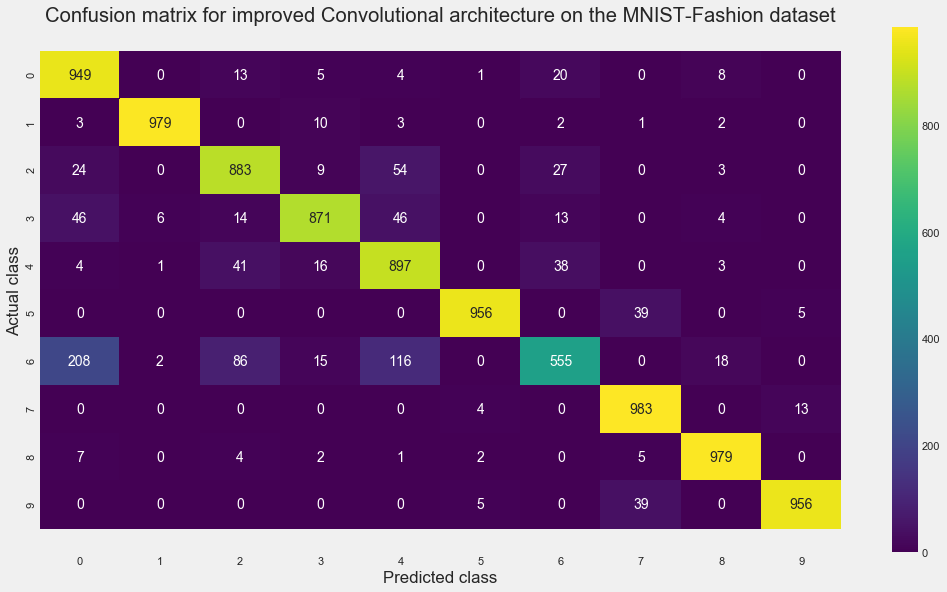

In [69]:
plotConfusionMatrix(testY, predictionCNN2, "Confusion matrix for improved Convolutional architecture on the MNIST-Fashion dataset")

The model sometimes perform slightly better on the test set, this could be either due to random chance or, more probably, beacuse of the slightly higher number of datapoints given during training (since we no longer set 20% of the data aside for validation).

The new architecture performs very well all thrughout, with the only exception being class 6, which has a reacll 14% lower than the second worst class. However, in general it performes worse on upper body garments than the other classes. This could have been expected: the difference between a low resolutionm image of a jumper and of another upper-body garment is hard to spot even for a human.

Finally, here is a recap of the scores obtained by the various classification methods.

In [70]:
dfClassificationScores = dfClassificationScores.round(2)
dfClassificationScores.set_index("Method")

Precision  Accuracy
Method                           
KMeans             0.58      0.53
MLP                0.51      0.65
CNN                0.61      0.70
CNN Improved       0.90      0.90

# Task 3
See attached poster. Note that some of the images might be slightly different from the one in the notebook due to variation between different runs, and with a change in the style given the different media, however these are all aesthetic changes.

# Task 4.1

We will now perform PCA and NMF dimensionality reduction, and try to study whether they bare any correspondance to the true class of the dataset.

In [71]:
from sklearn.decomposition import PCA, NMF

def getDecomposition(method, X):
    method.fit(X)
    mat = method.components_
    mat = mat.reshape(mat.shape[0], trainX.shape[-1], trainX.shape[-1])
    return mat

pca = PCA(n_components=10)
PCADecomp = getDecomposition(pca, trainXFlat)

nmf = NMF(n_components=10)
NMFDecomp = getDecomposition(nmf, trainXFlat)

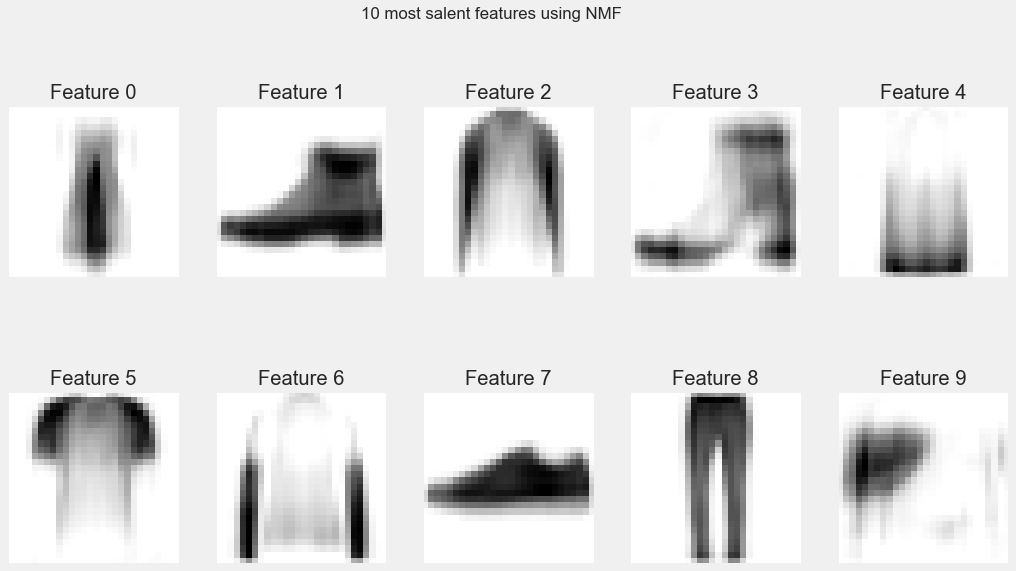

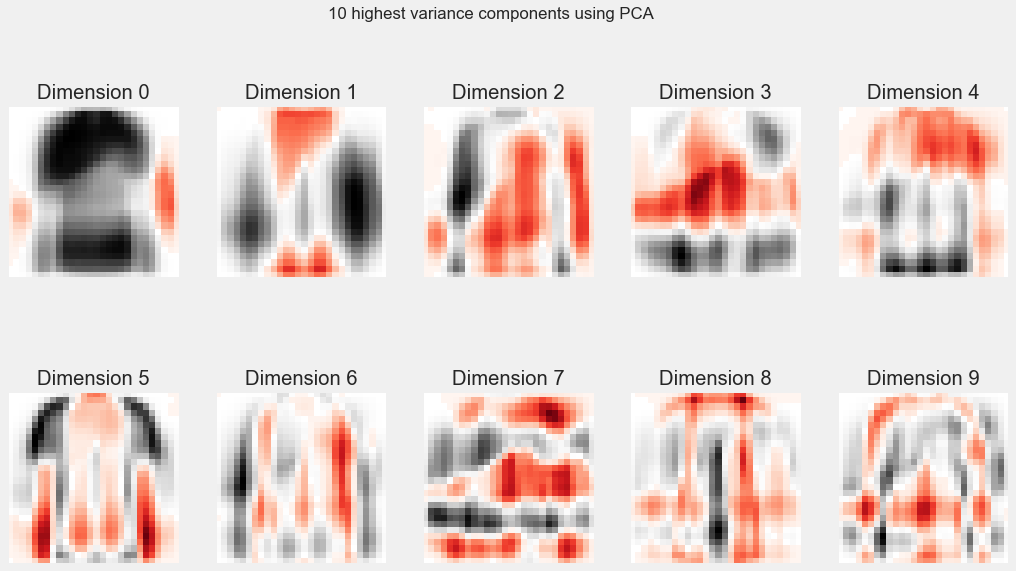

In [72]:
f,axes = plotImages(NMFDecomp, 2,5,False,False)
f.set_size_inches(16,9)
_=f.suptitle("10 most salent features using NMF")

for i in range(10):
    axes[i//5][i%5].set_title("Feature %d"%i)


f, axes = plotImages(PCADecomp,2,5,True,False)
f.set_size_inches(16,9)
_=f.suptitle("10 highest variance components using PCA")

for i in range(10):
    axes[i//5][i%5].set_title("Dimension %d"%i)

<a id="nmfCentroids"></a>
The above plots show, respectively, the features identified by the NMF decomposition and the direction of largest variance as given by PCA. Grays are used for positive values and reds for negative ones. The images produced by PCA don't have as obvious as visual interpretation as thos produced by NMF, this is in line with the findings in [5](#references). Still, many of the images produced from PCA can be seen to be strongly related to upper body garments, and negative images of shoes are visible for example in the third and 8th dimension. On the other hand, NMF seems to more closely follow the classes of the dataset, however they are not a one to one correspondence. For example, feature 6 is more clearly representing "long sleeves" rather than any particular class. In other words the features appear to be small details rather than identifying particular classes.

We now try to verify quantitatively the relation between classes and features, and do the same for classes and directions of variance. Refer to [this figure](#MNIST-classes) for representatives of each class.

## First method
In both methods we divide the data into the 10 classes. In the first case, we take the product of each image in each class with the mask obtained either from PCA or NMF, take the sum of the pixel values for each image and average it between classes. We take the absolute value as high negative correlation is as important as high positive correlation (this is only relevant for PCA as NMF only has positive values). We then normalise by class: empirically this gives results more in line with our intuition than normalising by feature/dimension.

In [113]:
#The images are divided into the ten classes, and each image is normalised so as to have equal sum
normalisedIndividualClasses = individualClasses / np.linalg.norm(individualClasses,axis=2,keepdims=True)

In [114]:
def getClassCorrespondance(decomposition):
    decomposition = np.transpose(decomposition.reshape(10,-1))

    matMul = np.abs(normalisedIndividualClasses @ decomposition)
    matMul = np.average(matMul,axis=1)
    
    return matMul



NMFCorr = getClassCorrespondance(NMFDecomp)
PCACorr = getClassCorrespondance(PCADecomp)

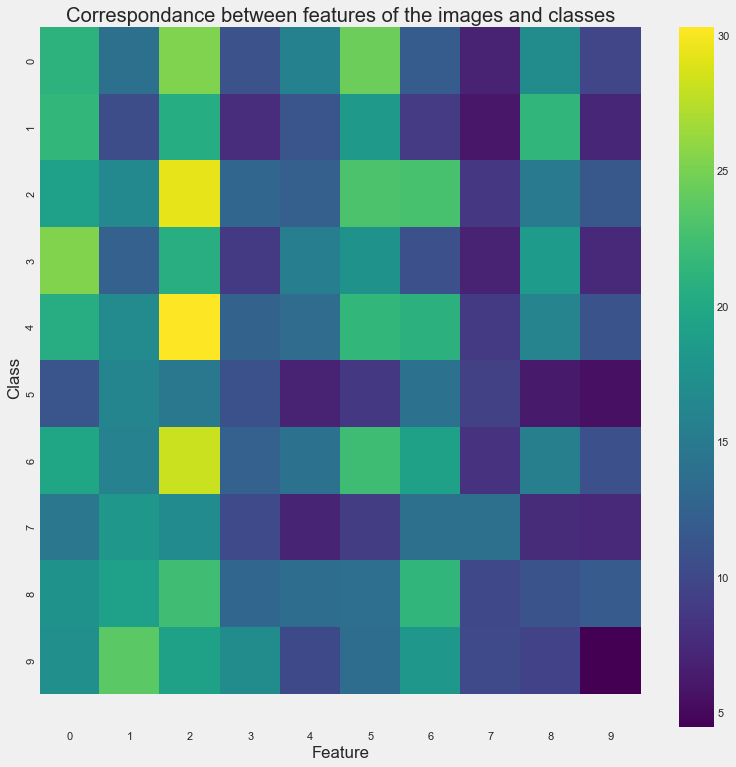

In [115]:
def plotCorr(corr, xlabel = "", title = "", cmap="viridis"):
    sns.heatmap(corr, cmap=cmap)
    plt.xlabel(xlabel)
    plt.ylabel("Class")
    plt.title(title)
    plt.gca().set_ylim(corr.shape[0]+0.5, 0)
    
    plt.gcf().set_size_inches(12,12)
    plt.show()

plotCorr(NMFCorr, "Feature", "Correspondance between features of the images and classes")

This plots is in line with our expectations: take for example columns 7 and 8. The first should clearly represent a sneaker, and in fact the most relevant class is xlass 7: sneakers. Similarly class 8 which is visually similar to trouser is highly correlated with class one. In general the features align with our intuition quite well.

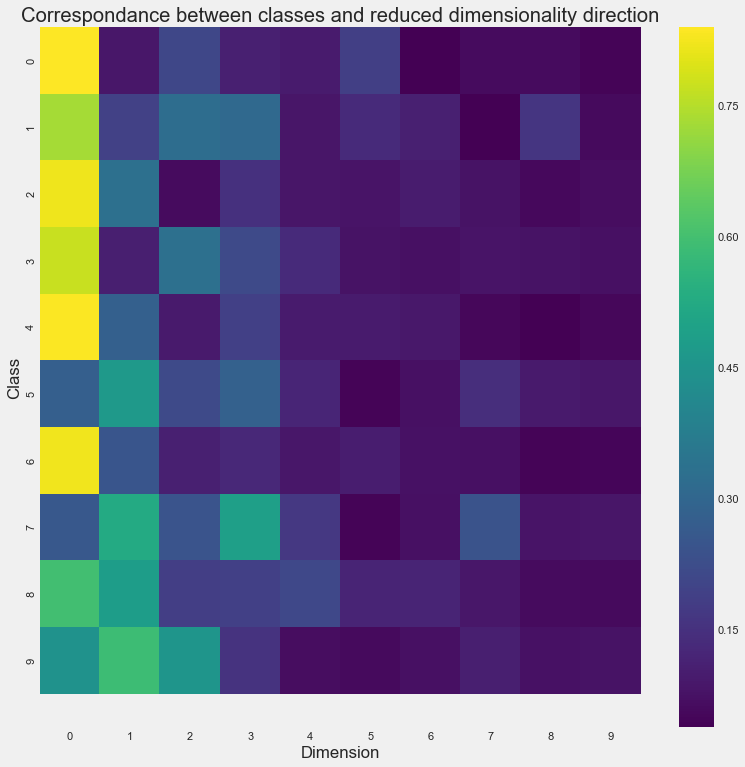

In [116]:
plotCorr(PCACorr, "Dimension", "Correspondance between classes and reduced dimensionality direction")

PCA doesn't give as good of a result as before, we mainly see how more important features are indeed more highly related to classes in general. A good graphical correspondence can be seen for example by looking at dimensions 3 and 7 which clearly show the negative image of a sneaker, and class 7. Or class 5 and column 1 which (squinting the eyes quite a bit) indeed shows a high-heeled shoe.

## Second method
The second method is more standard, [5](#references): each image is projected onto the 10 dimensions/features, this gives for each image the strength of the correlation with each of the dimensions/features. Again we take the absolute value and average among members of each class.

In [133]:
def getBetterCorr(decompMethod):

    return np.array([np.average(
                        np.abs(
                        decompMethod.transform(
                        normalisedIndividualClasses[i]
                        )),axis=0)
                     for i in range(10)])

nmfBetterCorr = getBetterCorr(nmf)
pcaBetterCorr = getBetterCorr(pca)

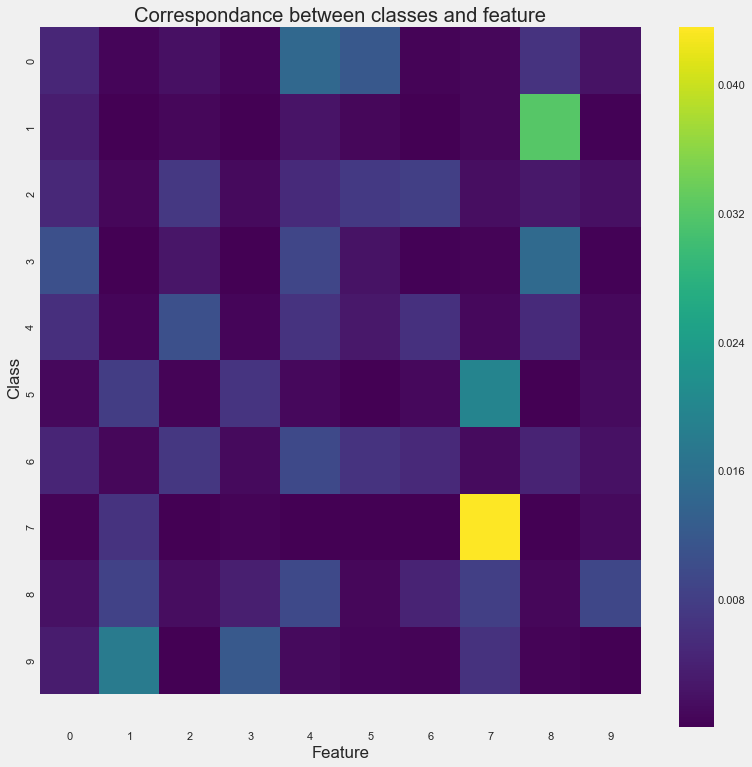

In [136]:
plotCorr(nmfBetterCorr, "Feature", "Correspondance between classes and feature")

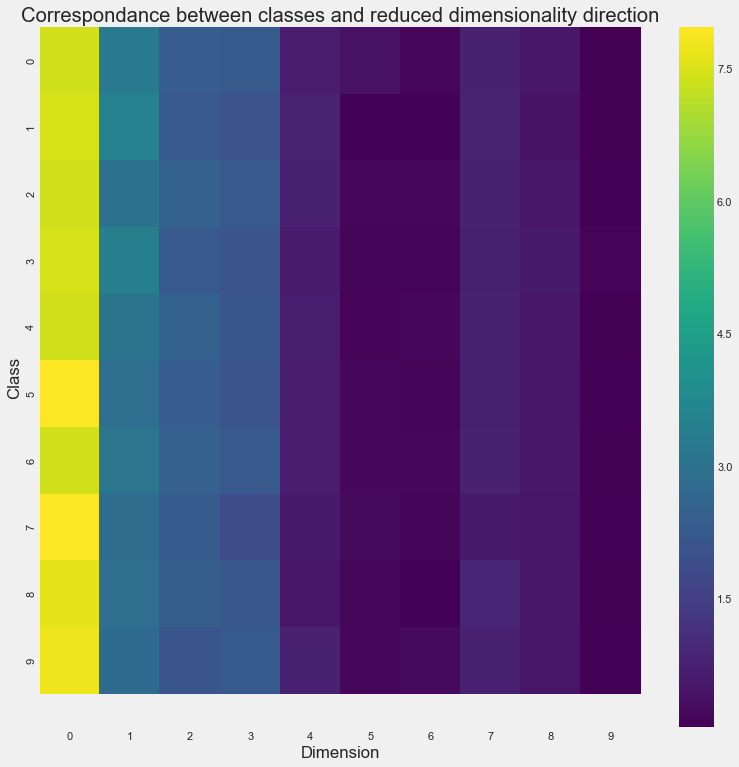

In [135]:
plotCorr(pcaBetterCorr, "Dimension", "Correspondance between classes and reduced dimensionality direction")

The second method seems to give a more reasonable answer for the NMF method, while for the PCA is seems top mostly show the greater importance of the most relevant direction, as would be expected given the nature of PCA.

## Qualitative comparison
Finally we project the data onto 2d space along the 2 most relevant directions/features given by PCA and NMF, to see if there is some visual correspondance to the 10 classes. Unfortunately, for obvious reason we cannot plot the data onto 10 dimensions, as that would be very hard to visualise. But this should still be able to tell us how well the two methods divide the labels. The justification for using this method can be found in the discussion [here](#PCA).

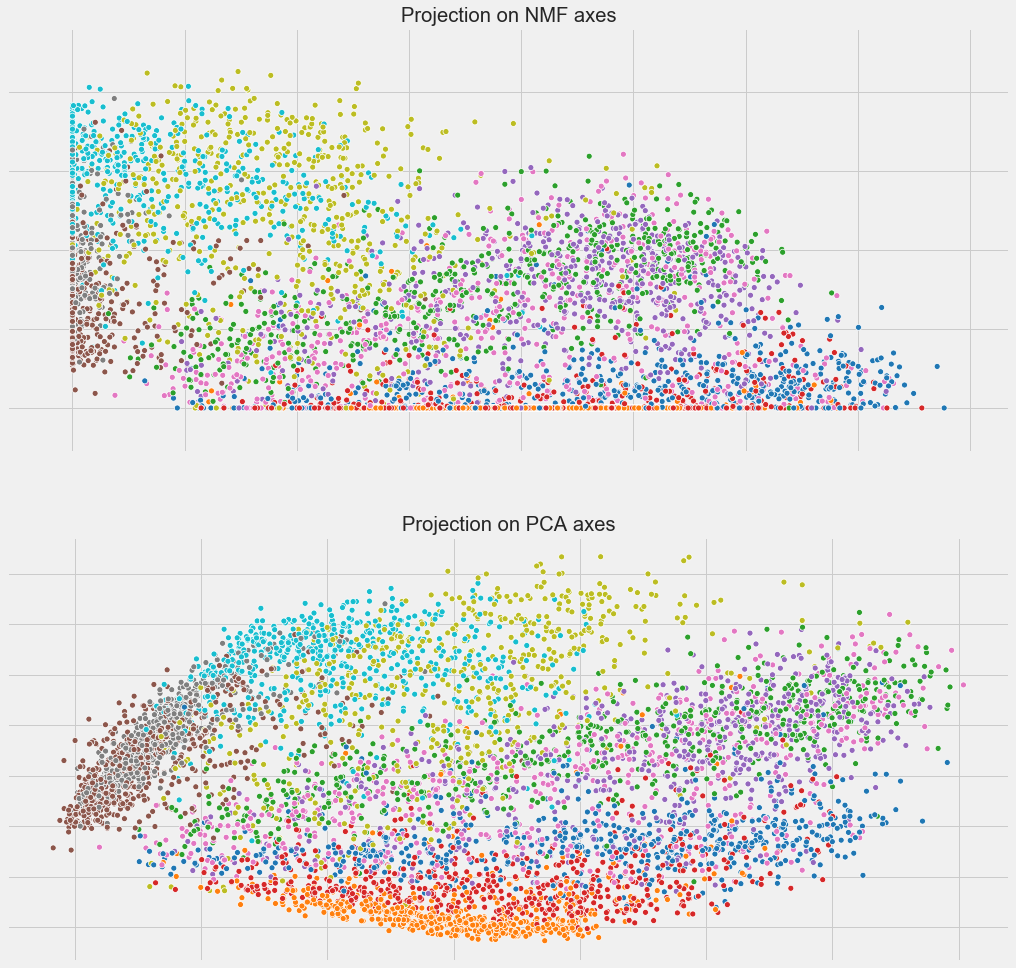

In [171]:
#use PCA to project the data on the 2 most important directions
projectedNMF = NMF(n_components = 2).fit_transform(trainXFlat)    
dfNMF = pd.DataFrame(columns = ["x","y"],data = projectedNMF)
dfNMF["labelTrue"] = trainY

projectedPCA = PCA(n_components = 2).fit_transform(trainXFlat)
dfPCA = pd.DataFrame(columns = ["x","y"],data = projectedPCA)
dfPCA["labelTrue"] = trainY

f, (ax1,ax2) = plt.subplots(nrows = 2,ncols = 1, sharex = False)
frequency = 10
sns.scatterplot(x="x",y="y",hue="labelTrue",data=dfNMF.iloc[::frequency],palette="tab10",ax=ax1)
ax1.set_title("Projection on NMF axes")
ax1.get_legend().remove()
ax1.set_xticklabels(['']*len(ax1.get_xticklabels()))
ax1.set_yticklabels(['']*len(ax1.get_yticklabels()))
ax1.set_ylabel(None)
ax1.set_xlabel(None)


sns.scatterplot(x="x",y="y",hue="labelTrue",data=dfPCA.iloc[::frequency],palette="tab10",ax=ax2)
ax2.set_title("Projection on PCA axes")
ax2.get_legend().remove()
ax2.set_xticklabels(['']*len(ax2.get_xticklabels()))
ax2.set_yticklabels(['']*len(ax2.get_yticklabels()))
ax2.set_ylabel(None)
ax2.set_xlabel(None)

f.set_size_inches(16,16)
plt.show()

PCA does seem to do a better job at dividing the labels, which would make it useful for dimensionality reduction for unsupervised methods. However, NMF seems to provide a good indicator for the presence of a certain feature, with many images lying at exactly 0, this makes it more useful to work in conjunction with supervised learning methods such as neural networks, where it could be used for automatically highlighting certain features, instead of needing longer training times for the network.

NMF could also be helpful in unsupervised learning, where it could easily extract complex features to be used as extra predictors by the clustering algorithms.

## Sparsity

In [162]:
def getSparsity(imgs):
    """
    Returns the number of pixels which are exactly 0 for each image
    in the array imgs
    """
    imgs = imgs.reshape(10,784)
    return np.sum(imgs==0, axis = 1)

NMFSparsity = getSparsity(NMFDecomp)
PCASparsity = getSparsity(PCADecomp)

In [166]:
print("Sparsity of NMF features: ", NMFSparsity)

Sparsity of NMF features:  [507 379 341 214 386 302 304 481 451 248]


In [168]:
print("Sparsity of PCA dimensions: ", PCASparsity)

Sparsity of PCA dimensions:  [0 0 0 0 0 0 0 0 0 0]


As can be seen above, the images produced by NMF can be quite sparse, with more than half of the pixels being exactly equal to zero, while those produced by PCA aren't sparse at all. Sparsity is extremely important for feature recognition [5](#references), so this is not a surprising result. We would expect to see better visual correspondance to the 10 classes in the images produced by NMF, if we assume that each class can be classified as an individual feature. Though there is some evidence of this, the correspondance is clearly not one-to-one: simply compare the [centroids produced by NMF](#nmfCentroids) to the [real centres](#centres) or those produced by kMeans. 

This is a consequence of multiple features being allowed to appear within the same image, so that, for example, features 5 (upper sleaves) and 6 (lower sleaves) combine to give the single feature sleaves. These can furthered be combined with 1 to give a predictor for a certain image being a long-sleeved shirt. 

# Task 4.2

In [80]:
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(learning_method = 'online', n_components=10, n_jobs = -1, verbose = 1, random_state = 1)
LDADecomp = getDecomposition(LDA, trainXFlat)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


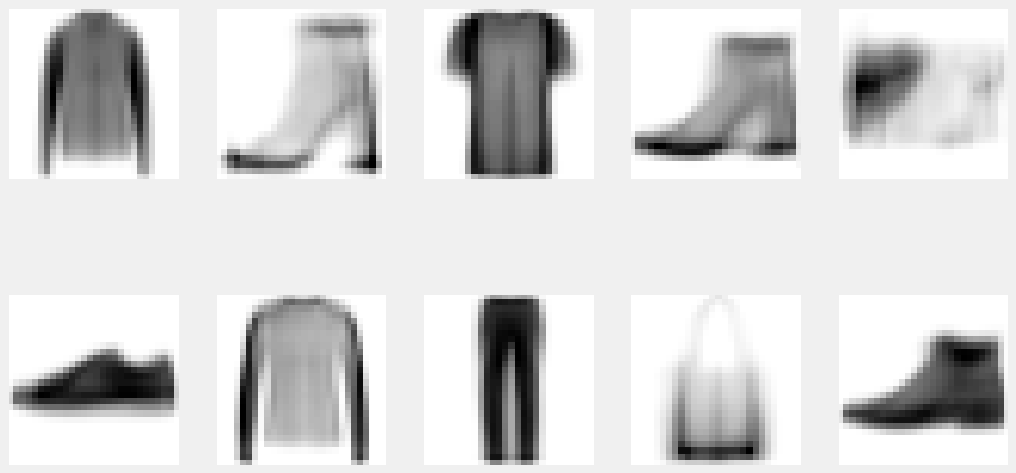

In [81]:
f,_ = plotImages(LDADecomp, 2,5,False,False)
f.set_size_inches(16,9)

While the images above show some very clear correspondance to visual features, there isn't a clear distinction into the 10 classes. This is to be expected: LDAs fundamental model is built exactly to allow different topics to appear within the same text document [4](#references) (which corresponds to a single image). Thus, more than 10 topics should be allowed to be identified by the algorithm. LDA has actually been proven to be quite effective at automated image classification [3](#references), however more care is needed than simply applying LDA and using the resulting centroids as a nearest neighbour classifier. In [3](#references) each image is split into different regions, the topics/features of each image are found and, during training, are associated with the corresponding caption. 

The performance provided by this approach was state-of-the-art in 2003, when the method was first introduced, but has long been surpassed by approaches based on neural networks.

Visually, the centroids are similar to thos produced by NMF, though more "smoothed out". Rather than features, LDA should be interpreted as producing probability distribution for pixels, classification can then be done via maximum likelihood estimates, though smoothing is necessary to get acceptable performance [4](#references). To understand why, consider how turning on and off a single pixel in a region with sparsity zero might affect the estimated likelihood.

Comparing the centroids to those found in [2.1](#Task-2.1), we see some similarity, however the centroids in 2.1 are more fuzzy compared to the more clear-cut ones produced by LDA, this probably makes LDA not that well suited for nearest neighbor classification.

# <a id ="references">References</a>


1. Pakhira MK, Bandyopadhyay S, Maulik U. _Validity index for crisp and fuzzy clusters._ Pattern recognition. 2004 Mar 1;37(3):487-501.

2. Bezdek JC, Pal NR. _Some New Indexes of Cluster Validity_. IEEE TRANSACTIONS ON SYSTEMS, MAN, AND CYBERNETICS—PART B: CYBERNETICS. 1998 Jun;28(3):301.

3. Blei DM, Jordan MI. _Modeling annotated data_. InProceedings of the 26th annual international ACM SIGIR conference on Research and development in informaion retrieval 2003 Jul 28 (pp. 127-134). ACM.

4. Blei DM, Ng AY, Jordan MI. _Latent dirichlet allocation_. Journal of machine Learning research. 2003;3(Jan):993-1022.

5. Lee DD, Seung HS. _Learning the parts of objects by non-negative matrix factorization._ Nature. 1999 Oct;401(6755):788.

6. Szegedy C, Ioffe S, Vanhoucke V, Alemi AA. _Inception-v4, inception-resnet and the impact of residual connections on learning_. InThirty-First AAAI Conference on Artificial Intelligence 2017 Feb 12.

7. Kingma DP, Ba J. _Adam: A method for stochastic optimization._ arXiv preprint arXiv:1412.6980. 2014 Dec 22.

8. Krizhevsky A, Sutskever I, Hinton GE. _Imagenet classification with deep convolutional neural networks_. In Advances in neural information processing systems 2012 (pp. 1097-1105).

9. Xie Q, Hovy E, Luong MT, Le QV. _Self-training with Noisy Student improves ImageNet classification._ arXiv preprint arXiv:1911.04252. 2019 Nov 11.

10. Tan M, Le QV. _EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks._ arXiv preprint arXiv:1905.11946. 2019 May 28.

11. Ioffe S, Szegedy C. _Batch normalization: Accelerating deep network training by reducing internal covariate shift_. arXiv preprint arXiv:1502.03167. 2015 Feb 11.